<a href="https://colab.research.google.com/github/SeptiLutfiana/PCVK_Ganjil_2023/blob/main/UAS_PCVK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Library

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import drive
import imutils
import cv2

from google.colab.patches import cv2_imshow

## Mounter

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Method

### Image

In [ ]:
def load_image(file_path):
    """
    Load an image from the specified file path.

    Parameters:
    - file_path (str): Path to the image file.

    Returns:
    - numpy.ndarray: Loaded image in RGB format.
    """
    img = cv2.imread(file_path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def compare_images(original, processed, title_before='Original', title_after='Processed', cmap=None):
    """
    Display a side-by-side comparison of two images.

    Parameters:
    - original (numpy.ndarray): Original image.
    - processed (numpy.ndarray): Processed image.
    - title_before (str): Title for the original image (default is 'Original').
    - title_after (str): Title for the processed image (default is 'Processed').
    - cmap (str): Colormap for displaying the images (default is None).
    """
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original, cmap=cmap)
    plt.title(title_before)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(processed, cmap=cmap)
    plt.title(title_after)
    plt.axis('off')

    plt.show()

def load_and_resize_image(file_path, desired_width=2000):
    """
    Load an image, resize it while preserving the aspect ratio, and perform denoising.

    Parameters:
    - file_path (str): Path to the image file.
    - desired_width (int): Desired width for resizing (default is 2000).

    Returns:
    - numpy.ndarray: Resized and denoised image.
    """
    ktp_image = load_image(file_path)
    original_height, original_width = ktp_image.shape[:2]

    aspect_ratio = original_width / original_height
    desired_height = int(desired_width / aspect_ratio)

    # Resize the image
    resized_image = cv2.resize(ktp_image, (desired_width, desired_height))

    # Denoise the resized image
    ktp_denoised = cv2.fastNlMeansDenoisingColored(resized_image, None, h=7)

    return ktp_denoised


### Preprocessing

In [ ]:
def segmentation(brightened_image):
    """
    Perform image segmentation on the brightened image.

    Parameters:
    - brightened_image (numpy.ndarray): Input image.

    Returns:
    - numpy.ndarray: Segmented image.
    """
    gray_img = cv2.cvtColor(brightened_image, cv2.COLOR_BGR2GRAY)
    _, binary_img = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = np.ones((2, 3), np.uint8)
    smoothed_img = cv2.morphologyEx(binary_img, cv2.MORPH_CLOSE, kernel)
    row_histogram = np.sum(smoothed_img, axis=1)
    _, segmented_img = cv2.threshold(smoothed_img, 1, 255, cv2.THRESH_BINARY)
    cv2_imshow(segmented_img)

    return segmented_img

def rlsa_horizontal(img, threshold):
    """
    Perform Run-Length Smoothing Algorithm (RLSA) horizontally on the input image.

    Parameters:
    - img (numpy.ndarray): Input image.
    - threshold (int): Threshold value for smoothing.

    Returns:
    - numpy.ndarray: Resulting image after horizontal RLSA.
    """
    result = img.copy()
    height, width = img.shape[:2]

    for y in range(height):
        count = 0
        for x in range(width):
            if img[y, x] == 255:  # If pixel is white
                count += 1
            else:  # If pixel is black
                if count <= threshold:
                    result[y, x - count:x] = 0  # Smearing
                count = 0

        if count <= threshold:
            result[y, width - count:width] = 0  # Smearing

    return result

def rlsa_vertical(img, threshold):
    """
    Perform Run-Length Smoothing Algorithm (RLSA) vertically on the input image.

    Parameters:
    - img (numpy.ndarray): Input image.
    - threshold (int): Threshold value for smoothing.

    Returns:
    - numpy.ndarray: Resulting image after vertical RLSA.
    """
    result = img.copy()
    height, width = img.shape[:2]

    for x in range(width):
        count = 0
        for y in range(height):
            if img[y, x] == 255:  # If pixel is white
                count += 1
            else:  # If pixel is black
                if count <= threshold:
                    result[y - count:y, x] = 0  # Smearing
                count = 0

        if count <= threshold:
            result[height - count:height, x] = 0  # Smearing

    return result

def preprocess_image_for_segmentation(image):
    """
    Preprocess the image for segmentation by converting it to grayscale and applying thresholding.

    Parameters:
    - image (numpy.ndarray): Input image.

    Returns:
    - numpy.ndarray: Processed image.
    """
    ktp_image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, threshed = cv2.threshold(ktp_image_gray, 127, 255, cv2.THRESH_TRUNC)
    _, binary_img = cv2.threshold(threshed, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = np.ones((3, 2), np.uint8)
    smoothed_img = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, kernel)

    return smoothed_img

#### Contours Detection

In [ ]:
def find_contours(img):
    """
    Find contours in the input image.

    Parameters:
    - img (numpy.ndarray): Input image.

    Returns:
    - list: List of contours.
    """
    conts = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    conts = imutils.grab_contours(conts)
    conts = sorted(conts, key=lambda x: cv2.boundingRect(x)[1])  # Sort contours based on y-coordinate first
    conts = sorted(conts, key=lambda x: cv2.boundingRect(x)[0])  # Then, sort contours based on x-coordinate

    return conts

def draw_bounding_boxes(image, contours):
    """
    Draw bounding boxes around contours on the input image.

    Parameters:
    - image (numpy.ndarray): Input image.
    - contours (list): List of contours.

    Returns:
    - numpy.ndarray: Image with bounding boxes drawn.
    """
    result = image.copy()
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(result, (x, y), (x+w, y+h), (0, 255, 0), 2)
    return result

#### RLSA

In [ ]:
def perform_rlsa_and_contour_detection(image, horizontal_threshold=30, vertical_threshold=5):
    """
    Perform Run-Length Smoothing Algorithm (RLSA) and contour detection on the input image.

    Parameters:
    - image (numpy.ndarray): Input image.
    - horizontal_threshold (int): Threshold for horizontal RLSA (default is 30).
    - vertical_threshold (int): Threshold for vertical RLSA (default is 5).

    Returns:
    - numpy.ndarray: Resulting image after RLSA.
    - list: List of contours.
    """
    rlsa_horizontal_result = rlsa_horizontal(image, threshold=horizontal_threshold)
    rlsa_result = rlsa_vertical(rlsa_horizontal_result, threshold=vertical_threshold)

    rlsa_combined = 255 - rlsa_result
    contours = find_contours(rlsa_combined)

    return rlsa_combined, contours

### Processing

In [ ]:
def preprocess_ktp_image(image_path, desired_width=2000):
    """
    Preprocess a KTP image by resizing, denoising, thresholding, and segmenting.

    Parameters:
    - image_path (str): Path to the KTP image.
    - desired_width (int): Desired width after resizing (default is 2000).

    Returns:
    - tuple: Tuple containing original image, thresholded image, smoothed image, and segmented image.
    """
    ktp_image = load_image(image_path)
    original_height, original_width = ktp_image.shape[:2]

    # Calculate the new dimensions while preserving the aspect ratio
    aspect_ratio = original_width / original_height
    desired_height = int(desired_width / aspect_ratio)

    # Resize the image
    resized_image = cv2.resize(ktp_image, (desired_width, desired_height))

    # Denoise the resized image
    ktp_denoised = cv2.fastNlMeansDenoisingColored(resized_image, None, h=7)
    ktp_image_gray = cv2.cvtColor(ktp_denoised, cv2.COLOR_BGR2GRAY)

    # Thresholding
    ret, threshed = cv2.threshold(ktp_image_gray, 127, 255, cv2.THRESH_TRUNC)

    # Binary image
    _, binary_img = cv2.threshold(threshed, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Smoothing
    kernel = np.ones((3, 2), np.uint8)
    smoothed_img = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, kernel)

    # Segmentation
    _, segmented_img = cv2.threshold(smoothed_img, 1, 255, cv2.THRESH_BINARY)

    return ktp_image, threshed, smoothed_img, segmented_img

def process_contours(contours, segmented_img, min_w=10, max_w=None, min_h=10, max_h=140):
    """
    Process contours, extract characters, and merge boxes.

    Parameters:
    - contours (list): List of contours.
    - segmented_img (numpy.ndarray): Segmented image.
    - min_w (int): Minimum width for a box (default is 10).
    - max_w (int): Maximum width for a box (default is None).
    - min_h (int): Minimum height for a box (default is 10).
    - max_h (int): Maximum height for a box (default is 140).

    Returns:
    - tuple: Tuple containing merged boxes, detected characters, and corresponding ROIs.
    """


    img_copy = segmented_img.copy()
    detected_char = []
    texts_roi = []

    for idx, c in enumerate(contours):
        (x, y, w, h) = cv2.boundingRect(c)

        if (w >= min_w and (max_w is None or w <= max_w)) and (h >= min_h and h <= max_h):
            cv2.rectangle(img_copy, (x, y), (x+w, y+h), (255, 255, 255), 2)

            # Process the box and extract character
            roi = extract_roi(segmented_img, x, y, w, h)
            thresh = thresholding(roi)
            (h, w) = thresh.shape
            resized = resize_img(thresh, w, h)
            normalized = normalization(resized)

            detected_char.append((normalized, (x, y, w, h)))
            texts_roi.append(roi)

    merged_boxes = []
    current_box = None

    for box in detected_char:
        if current_box is None:
            current_box = box
        else:
            _, (x1, y1, w1, h1) = current_box
            _, (x2, y2, w2, h2) = box
            if y1 <= y2 <= y1 + h1:
                current_box = (
                    np.concatenate([current_box[0], box[0]], axis=1),
                    (min(x1, x2), min(y1, y2), max(x1 + w1, x2 + w2) - min(x1, x2), max(y1 + h1, y2 + h2) - min(y1, y2))
                )
            else:
                merged_boxes.append(current_box)
                current_box = box

    if current_box is not None:
        merged_boxes.append(current_box)

    return merged_boxes, detected_char, texts_roi

def draw_merged_boxes(image, merged_boxes):
    """
    Draw merged boxes on the input image.

    Parameters:
    - image (numpy.ndarray): Input image.
    - merged_boxes (list): List of merged boxes.

    Returns:
    - numpy.ndarray: Image with merged boxes drawn.
    """
    img_copy = image.copy()

    for box in merged_boxes:
        _, (x, y, w, h) = box
        cv2.rectangle(img_copy, (x, y), (x+w, y+h), (255, 0, 0), 4)

    return img_copy

In [ ]:
def filter_contours_by_size(contours, min_w, max_w, min_h, max_h):
    """
    Filter contours based on width and height criteria.

    Parameters:
    - contours (list): List of contours.
    - min_w (int): Minimum width.
    - max_w (int): Maximum width.
    - min_h (int): Minimum height.
    - max_h (int): Maximum height.

    Returns:
    - list: Filtered list of contours.
    """
    filtered_contours = []

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)

        if min_w <= w <= max_w and min_h <= h <= max_h:
            filtered_contours.append(contour)

    return filtered_contours

def merge_overlapping_boxes(boxes):
    """
    Merge overlapping boxes.

    Parameters:
    - boxes (list): List of boxes.

    Returns:
    - list: Merged list of boxes.
    """
    merged_boxes = []
    current_box = None

    for box in boxes:
        if current_box is None:
            current_box = box
        else:
            _, (x1, y1, w1, h1) = current_box
            _, (x2, y2, w2, h2) = box
            if y1 <= y2 <= y1 + h1:
                current_box = (
                    np.concatenate([current_box[0], box[0]], axis=1),
                    (min(x1, x2), min(y1, y2), max(x1 + w1, x2 + w2) - min(x1, x2), max(y1 + h1, y2 + h2) - min(y1, y2))
                )
            else:
                merged_boxes.append(current_box)
                current_box = box

    if current_box is not None:
        merged_boxes.append(current_box)

    return merged_boxes

def draw_merged_boxes(image, merged_boxes, color=(255, 0, 0), thickness=4):
    """
    Draw merged boxes on the image.

    Parameters:
    - image (numpy.ndarray): Input image.
    - merged_boxes (list): List of merged boxes.
    - color (tuple): BGR color for drawing (default is red).
    - thickness (int): Thickness of the bounding box (default is 4).

    Returns:
    - numpy.ndarray: Image with merged boxes drawn.
    """
    img_copy = image.copy()

    for box in merged_boxes:
        _, (x, y, w, h) = box
        cv2.rectangle(img_copy, (x, y), (x + w, y + h), color, thickness)

    return img_copy

### Model

In [ ]:
def convert_to_char(prediction):
    """
    Convert a model prediction to a character based on the predicted class.

    Parameters:
    - prediction (numpy.ndarray): Model prediction.

    Returns:
    - str: Predicted character.
    """
    class_index = np.argmax(prediction)
    character_mapping = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ"
    predicted_char = character_mapping[class_index]

    return predicted_char

## Pre Processing

### Directory

In [ ]:
DATADIR = "/content/drive/MyDrive/project-ktp-semester-4/"
folders_by_name = ['alizul', 'septi', 'fikri', 'ilham', 'izza']
folders_cropped = 'cropped/'

folder_path = os.path.join(DATADIR, folders_cropped)

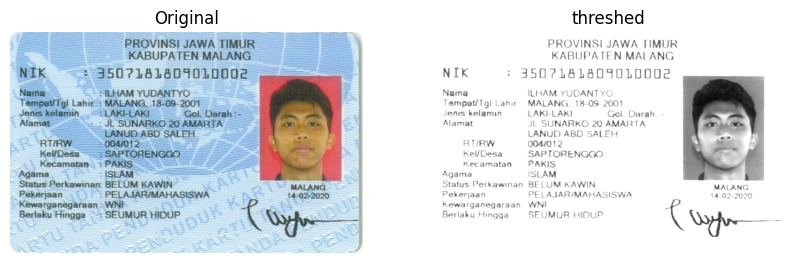

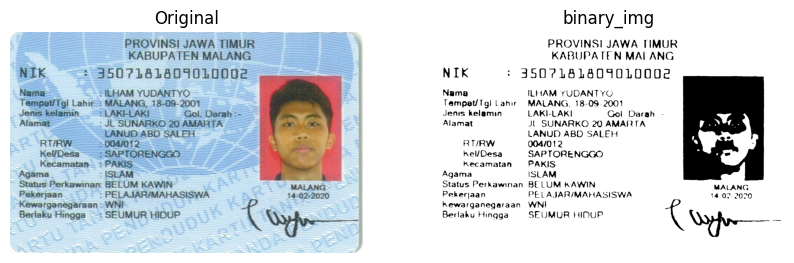

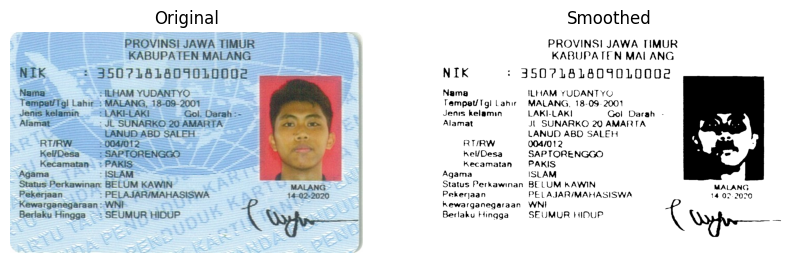

In [ ]:
for i in range(20, 21):
    filename = f"{i}.png"
    img_path = os.path.join(folder_path, filename)

    if os.path.exists(img_path):
        ktp_image = load_image(img_path)
        original_height, original_width = ktp_image.shape[:2]

        # Calculate the new dimensions while preserving the aspect ratio
        desired_width = 2000
        aspect_ratio = original_width / original_height
        desired_height = int(desired_width / aspect_ratio)

        # Resize the image
        resized_image = cv2.resize(ktp_image, (desired_width, desired_height))

        ktp_denoised = cv2.fastNlMeansDenoisingColored(resized_image, None, h=7)
        ktp_image_gray = cv2.cvtColor(ktp_denoised, cv2.COLOR_BGR2GRAY)
        ret, threshed = cv2.threshold(ktp_image_gray, 155, 255, cv2.THRESH_TRUNC)
        _, binary_img = cv2.threshold(threshed, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        kernel = np.ones((3,2), np.uint8)
        smoothed_img = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, kernel)

        segmented_img = smoothed_img

        rlsa_horizontal_result = rlsa_horizontal(smoothed_img, threshold=30)
        rlsa_result = rlsa_vertical(rlsa_horizontal_result, threshold=5)

        rlsa_combined = 255 - rlsa_result
        contours = find_contours(rlsa_combined)

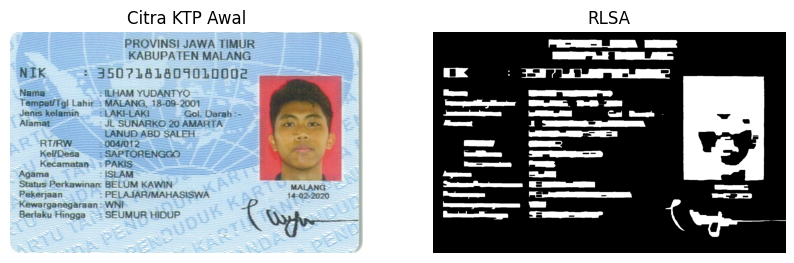

In [ ]:
compare_images(ktp_image, rlsa_combined, title_before="Citra KTP Awal", title_after="RLSA", cmap="gray")

## Method Temporary

In [ ]:
def extract_roi(img, x, y, w, h):
    roi = img[y:y+h, x:x+w]
    return roi

def thresholding(img):
    thresh = cv2.threshold(img, 127, 255,cv2.THRESH_TRUNC + cv2.THRESH_OTSU)[1]
    return thresh

def resize_img(img, w, h):
    if w > h:
        resized = imutils.resize(img, width=28)
    else:
        resized = imutils.resize(img, height=28)

    (h, w) = resized.shape

    dX = int(max(0, 28 - w) / 2.0)
    dY = int(max(0, 28 - h) / 2.0)

    filled = cv2.copyMakeBorder(resized, top=dY, bottom=dY, right=dX, left=dX, borderType=cv2.BORDER_CONSTANT, value=(0,0,0))
    filled = cv2.resize(filled, (28, 28))

    return filled

def normalization(img):
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=-1)
    return img

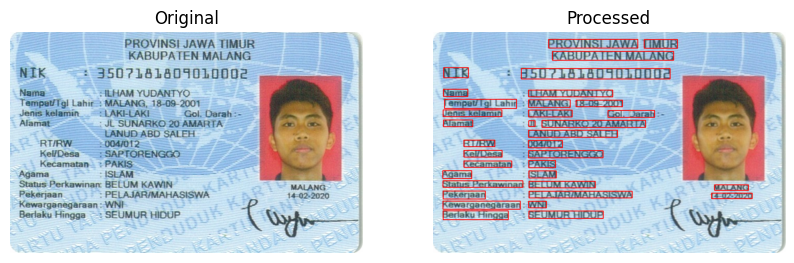

In [ ]:
(imh, imw, _) = resized_image.shape

min_w, max_w = 10, imw
min_h, max_h = 10, 140
img_copy = resized_image.copy()

detected_char = []
texts_roi = []

for idx, c in enumerate(contours):
    (x, y, w, h) = cv2.boundingRect(c)

    if (w >= min_w and w <= max_w) and (h >= min_h and h <= max_h):
        cv2.rectangle(img_copy, (x, y), (x+w, y+h), (255, 255, 255), 2)

        # Process the box and extract character
        roi = extract_roi(segmented_img, x, y, w, h)
        thresh = thresholding(roi)
        (h, w) = thresh.shape
        resized = resize_img(thresh, w, h)
        normalized = normalization(resized)

        detected_char.append((normalized, (x, y, w, h)))
        texts_roi.append(roi)

merged_boxes = []
current_box = None

for box in detected_char:
    if current_box is None:
        current_box = box
    else:
        _, (x1, y1, w1, h1) = current_box
        _, (x2, y2, w2, h2) = box
        if y1 <= y2 <= y1 + h1:
            current_box = (np.concatenate([current_box[0], box[0]], axis=1), (min(x1, x2), min(y1, y2), max(x1 + w1, x2 + w2) - min(x1, x2), max(y1 + h1, y2 + h2) - min(y1, y2)))
        else:
            merged_boxes.append(current_box)
            current_box = box

if current_box is not None:
    merged_boxes.append(current_box)

for box in merged_boxes:
    _, (x, y, w, h) = box
    cv2.rectangle(img_copy, (x, y), (x+w, y+h), (255, 0, 0), 4)

compare_images(ktp_image, img_copy)

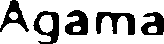

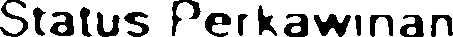

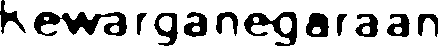

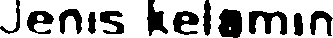

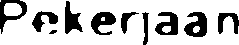

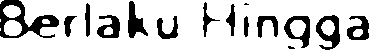

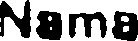

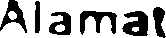

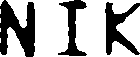

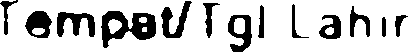

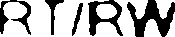

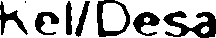

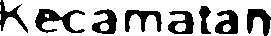

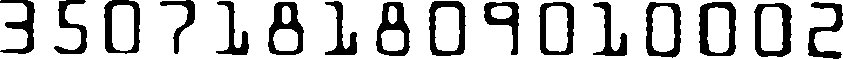

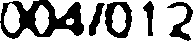

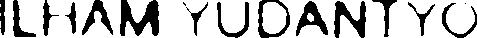

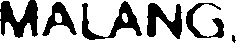

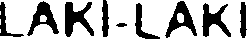

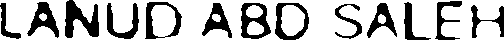

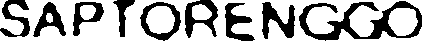

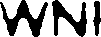

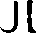

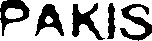

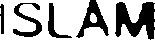

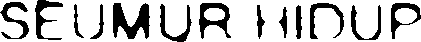

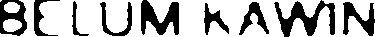

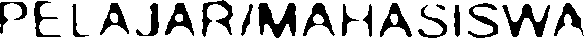

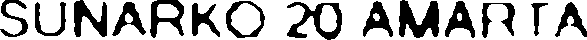

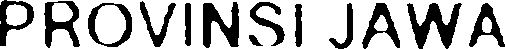

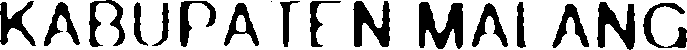

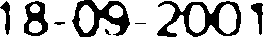

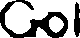

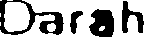

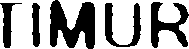

In [ ]:
for roi in texts_roi:
  cv2_imshow(roi)

## Model

In [ ]:
from keras.models import load_model

In [ ]:
model = load_model('./drive/MyDrive/project-ktp-semester-4/anpr_model.h5')

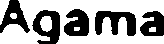

1/1 [==============================] - 0s 143ms/step
Predicted Character 1_1: A


1/1 [==============================] - 0s 119ms/step
Predicted Character 1_2: Q


1/1 [==============================] - 0s 116ms/step
Predicted Character 1_3: 3


1/1 [==============================] - 0s 123ms/step
Predicted Character 1_4: M


1/1 [==============================] - 0s 127ms/step
Predicted Character 1_5: 3


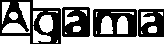

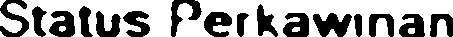

1/1 [==============================] - 0s 81ms/step
Predicted Character 2_1: S


1/1 [==============================] - 0s 122ms/step
Predicted Character 2_2: C


1/1 [==============================] - 0s 134ms/step
Predicted Character 2_3: 3


1/1 [==============================] - 0s 94ms/step
Predicted Character 2_4: C


1/1 [==============================] - 0s 134ms/step
Predicted Character 2_5: U


1/1 [==============================] - 0s 38ms/step
Predicted Character 2_6: S


1/1 [==============================] - 0s 89ms/step
Predicted Character 2_7: P


1/1 [==============================] - 0s 37ms/step
Predicted Character 2_8: C


1/1 [==============================] - 0s 110ms/step
Predicted Character 2_9: T


1/1 [==============================] - 0s 39ms/step
Predicted Character 2_10: K


1/1 [==============================] - 0s 39ms/step
Predicted Character 2_11: 8


1/1 [==============================] - 0s 52ms/step
Predicted Character 2_12: W


1/1 [==============================] - 0s 84ms/step
Predicted Character 2_13: 1


1/1 [==============================] - 0s 79ms/step
Predicted Character 2_14: M


1/1 [==============================] - 0s 64ms/step
Predicted Character 2_15: 8


1/1 [==============================] - 0s 49ms/step
Predicted Character 2_16: D


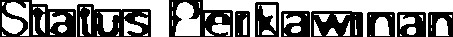

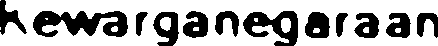

1/1 [==============================] - 0s 64ms/step
Predicted Character 3_1: K


1/1 [==============================] - 0s 77ms/step
Predicted Character 3_2: N


1/1 [==============================] - 0s 56ms/step
Predicted Character 3_3: F


1/1 [==============================] - 0s 43ms/step
Predicted Character 3_4: Q


1/1 [==============================] - 0s 39ms/step
Predicted Character 3_5: 8


1/1 [==============================] - 0s 49ms/step
Predicted Character 3_6: 0


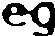

1/1 [==============================] - 0s 37ms/step
Predicted Character 3_7: W


1/1 [==============================] - 0s 43ms/step
Predicted Character 3_8: 8


1/1 [==============================] - 0s 49ms/step
Predicted Character 3_9: T


1/1 [==============================] - 0s 68ms/step
Predicted Character 3_10: 8


1/1 [==============================] - 0s 71ms/step
Predicted Character 3_11: 8


1/1 [==============================] - 0s 66ms/step
Predicted Character 3_12: P


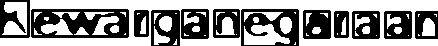

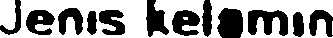

1/1 [==============================] - 0s 58ms/step
Predicted Character 4_1: J


1/1 [==============================] - 0s 86ms/step
Predicted Character 4_2: L


1/1 [==============================] - 0s 91ms/step
Predicted Character 4_3: N


1/1 [==============================] - 0s 70ms/step
Predicted Character 4_4: I


1/1 [==============================] - 0s 104ms/step
Predicted Character 4_5: S


1/1 [==============================] - 0s 47ms/step
Predicted Character 4_6: M


1/1 [==============================] - 0s 135ms/step
Predicted Character 4_7: L


1/1 [==============================] - 0s 85ms/step
Predicted Character 4_8: I


1/1 [==============================] - 0s 93ms/step
Predicted Character 4_9: 8


1/1 [==============================] - 0s 84ms/step
Predicted Character 4_10: M


1/1 [==============================] - 0s 45ms/step
Predicted Character 4_11: 9


1/1 [==============================] - 0s 83ms/step
Predicted Character 4_12: A


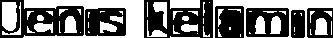

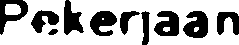

1/1 [==============================] - 0s 82ms/step
Predicted Character 5_1: H


1/1 [==============================] - 0s 89ms/step
Predicted Character 5_2: R


1/1 [==============================] - 0s 46ms/step
Predicted Character 5_3: 5


1/1 [==============================] - 0s 66ms/step
Predicted Character 5_4: R


1/1 [==============================] - 0s 56ms/step
Predicted Character 5_5: L


1/1 [==============================] - 0s 95ms/step
Predicted Character 5_6: C


1/1 [==============================] - 0s 46ms/step
Predicted Character 5_7: 1


1/1 [==============================] - 0s 47ms/step
Predicted Character 5_8: 8


1/1 [==============================] - 0s 62ms/step
Predicted Character 5_9: 8


1/1 [==============================] - 0s 59ms/step
Predicted Character 5_10: N


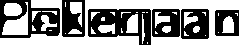

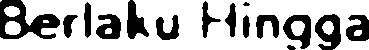

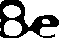

1/1 [==============================] - 0s 50ms/step
Predicted Character 6_1: H


1/1 [==============================] - 0s 70ms/step
Predicted Character 6_2: T


1/1 [==============================] - 0s 89ms/step
Predicted Character 6_3: I


1/1 [==============================] - 0s 50ms/step
Predicted Character 6_4: 8


1/1 [==============================] - 0s 95ms/step
Predicted Character 6_5: R


1/1 [==============================] - 0s 45ms/step
Predicted Character 6_6: U


1/1 [==============================] - 0s 88ms/step
Predicted Character 6_7: F


1/1 [==============================] - 0s 57ms/step
Predicted Character 6_8: 9


1/1 [==============================] - 0s 67ms/step
Predicted Character 6_9: 1


1/1 [==============================] - 0s 124ms/step
Predicted Character 6_10: 2


1/1 [==============================] - 0s 155ms/step
Predicted Character 6_11: M


1/1 [==============================] - 0s 159ms/step
Predicted Character 6_12: Q


1/1 [==============================] - 0s 113ms/step
Predicted Character 6_13: 6


1/1 [==============================] - 0s 132ms/step
Predicted Character 6_14: G


1/1 [==============================] - 0s 53ms/step
Predicted Character 6_15: 8


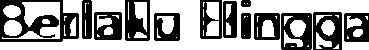

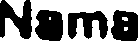

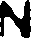

1/1 [==============================] - 0s 110ms/step
Predicted Character 7_1: N


1/1 [==============================] - 0s 157ms/step
Predicted Character 7_2: 8


1/1 [==============================] - 0s 118ms/step
Predicted Character 7_3: M


1/1 [==============================] - 0s 90ms/step
Predicted Character 7_4: 8


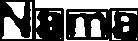

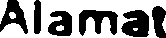

1/1 [==============================] - 0s 169ms/step
Predicted Character 8_1: A


1/1 [==============================] - 0s 129ms/step
Predicted Character 8_2: I


1/1 [==============================] - 0s 131ms/step
Predicted Character 8_3: 8


1/1 [==============================] - 0s 136ms/step
Predicted Character 8_4: M


1/1 [==============================] - 0s 137ms/step
Predicted Character 8_5: 8


1/1 [==============================] - 0s 160ms/step
Predicted Character 8_6: 2


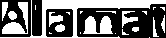

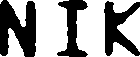

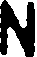

1/1 [==============================] - 0s 115ms/step
Predicted Character 9_1: N


1/1 [==============================] - 0s 136ms/step
Predicted Character 9_2: I


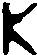

1/1 [==============================] - 0s 81ms/step
Predicted Character 9_3: K


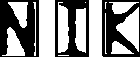

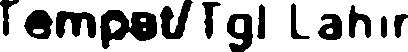

1/1 [==============================] - 0s 91ms/step
Predicted Character 10_1: F


1/1 [==============================] - 0s 91ms/step
Predicted Character 10_2: 8


1/1 [==============================] - 0s 129ms/step
Predicted Character 10_3: M


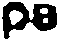

1/1 [==============================] - 0s 134ms/step
Predicted Character 10_4: P


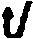

1/1 [==============================] - 0s 86ms/step
Predicted Character 10_5: U


1/1 [==============================] - 0s 113ms/step
Predicted Character 10_6: T


1/1 [==============================] - 0s 71ms/step
Predicted Character 10_7: 9


1/1 [==============================] - 0s 73ms/step
Predicted Character 10_8: 1


1/1 [==============================] - 0s 39ms/step
Predicted Character 10_9: L


1/1 [==============================] - 0s 47ms/step
Predicted Character 10_10: 8


1/1 [==============================] - 0s 55ms/step
Predicted Character 10_11: H


1/1 [==============================] - 0s 40ms/step
Predicted Character 10_12: 1


1/1 [==============================] - 0s 48ms/step
Predicted Character 10_13: F


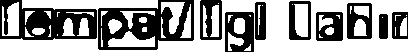

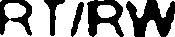

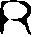

1/1 [==============================] - 0s 39ms/step
Predicted Character 11_1: R


1/1 [==============================] - 0s 49ms/step
Predicted Character 11_2: T


1/1 [==============================] - 0s 54ms/step
Predicted Character 11_3: Z


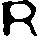

1/1 [==============================] - 0s 46ms/step
Predicted Character 11_4: R


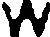

1/1 [==============================] - 0s 45ms/step
Predicted Character 11_5: W


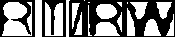

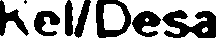

1/1 [==============================] - 0s 48ms/step
Predicted Character 12_1: K


1/1 [==============================] - 0s 69ms/step
Predicted Character 12_2: M


1/1 [==============================] - 0s 107ms/step
Predicted Character 12_3: C


1/1 [==============================] - 0s 45ms/step
Predicted Character 12_4: I


1/1 [==============================] - 0s 71ms/step
Predicted Character 12_5: Z


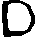

1/1 [==============================] - 0s 27ms/step
Predicted Character 12_6: D


1/1 [==============================] - 0s 27ms/step
Predicted Character 12_7: L


1/1 [==============================] - 0s 27ms/step
Predicted Character 12_8: N


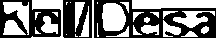

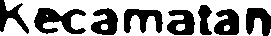

1/1 [==============================] - 0s 26ms/step
Predicted Character 13_1: K


1/1 [==============================] - 0s 27ms/step
Predicted Character 13_2: K


1/1 [==============================] - 0s 28ms/step
Predicted Character 13_3: 3


1/1 [==============================] - 0s 28ms/step
Predicted Character 13_4: M


1/1 [==============================] - 0s 28ms/step
Predicted Character 13_5: 8


1/1 [==============================] - 0s 27ms/step
Predicted Character 13_6: C


1/1 [==============================] - 0s 26ms/step
Predicted Character 13_7: 3


1/1 [==============================] - 0s 32ms/step
Predicted Character 13_8: N


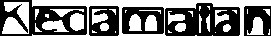

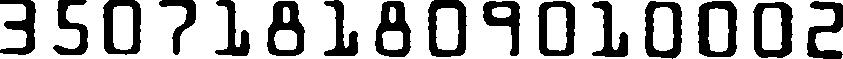

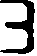

1/1 [==============================] - 0s 27ms/step
Predicted Character 14_1: 3


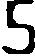

1/1 [==============================] - 0s 27ms/step
Predicted Character 14_2: 5


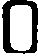

1/1 [==============================] - 0s 28ms/step
Predicted Character 14_3: U


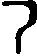

1/1 [==============================] - 0s 27ms/step
Predicted Character 14_4: 7


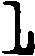

1/1 [==============================] - 0s 26ms/step
Predicted Character 14_5: L


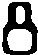

1/1 [==============================] - 0s 28ms/step
Predicted Character 14_6: B


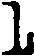

1/1 [==============================] - 0s 27ms/step
Predicted Character 14_7: L


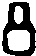

1/1 [==============================] - 0s 27ms/step
Predicted Character 14_8: B


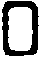

1/1 [==============================] - 0s 27ms/step
Predicted Character 14_9: C


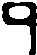

1/1 [==============================] - 0s 28ms/step
Predicted Character 14_10: 7


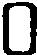

1/1 [==============================] - 0s 26ms/step
Predicted Character 14_11: M


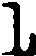

1/1 [==============================] - 0s 26ms/step
Predicted Character 14_12: L


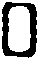

1/1 [==============================] - 0s 28ms/step
Predicted Character 14_13: 0


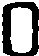

1/1 [==============================] - 0s 31ms/step
Predicted Character 14_14: E


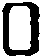

1/1 [==============================] - 0s 27ms/step
Predicted Character 14_15: 0


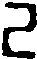

1/1 [==============================] - 0s 35ms/step
Predicted Character 14_16: E


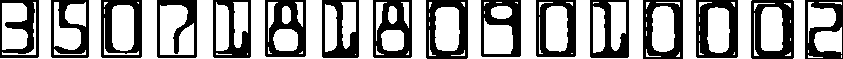

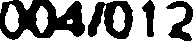

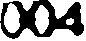

1/1 [==============================] - 0s 38ms/step
Predicted Character 15_1: M


1/1 [==============================] - 0s 27ms/step
Predicted Character 15_2: I


1/1 [==============================] - 0s 27ms/step
Predicted Character 15_3: C


1/1 [==============================] - 0s 31ms/step
Predicted Character 15_4: 1


1/1 [==============================] - 0s 27ms/step
Predicted Character 15_5: 2


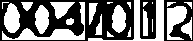

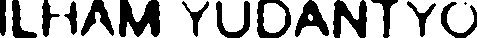

1/1 [==============================] - 0s 27ms/step
Predicted Character 16_1: F


1/1 [==============================] - 0s 27ms/step
Predicted Character 16_2: L


1/1 [==============================] - 0s 29ms/step
Predicted Character 16_3: H


1/1 [==============================] - 0s 28ms/step
Predicted Character 16_4: 9


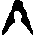

1/1 [==============================] - 0s 27ms/step
Predicted Character 16_5: A


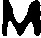

1/1 [==============================] - 0s 28ms/step
Predicted Character 16_6: M


1/1 [==============================] - 0s 27ms/step
Predicted Character 16_7: 6


1/1 [==============================] - 0s 27ms/step
Predicted Character 16_8: Y


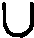

1/1 [==============================] - 0s 27ms/step
Predicted Character 16_9: U


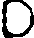

1/1 [==============================] - 0s 26ms/step
Predicted Character 16_10: D


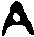

1/1 [==============================] - 0s 26ms/step
Predicted Character 16_11: A


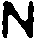

1/1 [==============================] - 0s 28ms/step
Predicted Character 16_12: N


1/1 [==============================] - 0s 27ms/step
Predicted Character 16_13: J


1/1 [==============================] - 0s 27ms/step
Predicted Character 16_14: Y


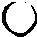

1/1 [==============================] - 0s 28ms/step
Predicted Character 16_15: C


1/1 [==============================] - 0s 29ms/step
Predicted Character 16_16: L


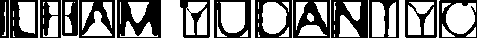

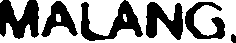

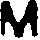

1/1 [==============================] - 0s 29ms/step
Predicted Character 17_1: M


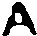

1/1 [==============================] - 0s 28ms/step
Predicted Character 17_2: A


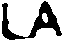

1/1 [==============================] - 0s 30ms/step
Predicted Character 17_3: J


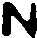

1/1 [==============================] - 0s 31ms/step
Predicted Character 17_4: N


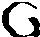

1/1 [==============================] - 0s 27ms/step
Predicted Character 17_5: G


1/1 [==============================] - 0s 27ms/step
Predicted Character 17_6: 4


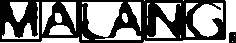

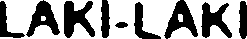

1/1 [==============================] - 0s 31ms/step
Predicted Character 18_1: L


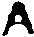

1/1 [==============================] - 0s 28ms/step
Predicted Character 18_2: A


1/1 [==============================] - 0s 27ms/step
Predicted Character 18_3: K


1/1 [==============================] - 0s 26ms/step
Predicted Character 18_4: 3


1/1 [==============================] - 0s 26ms/step
Predicted Character 18_5: 6


1/1 [==============================] - 0s 26ms/step
Predicted Character 18_6: L


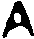

1/1 [==============================] - 0s 26ms/step
Predicted Character 18_7: A


1/1 [==============================] - 0s 26ms/step
Predicted Character 18_8: K


1/1 [==============================] - 0s 34ms/step
Predicted Character 18_9: I


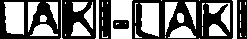

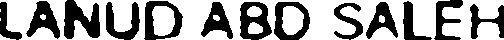

1/1 [==============================] - 0s 29ms/step
Predicted Character 19_1: L


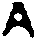

1/1 [==============================] - 0s 30ms/step
Predicted Character 19_2: A


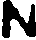

1/1 [==============================] - 0s 27ms/step
Predicted Character 19_3: N


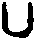

1/1 [==============================] - 0s 27ms/step
Predicted Character 19_4: U


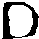

1/1 [==============================] - 0s 28ms/step
Predicted Character 19_5: D


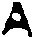

1/1 [==============================] - 0s 29ms/step
Predicted Character 19_6: A


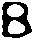

1/1 [==============================] - 0s 26ms/step
Predicted Character 19_7: B


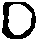

1/1 [==============================] - 0s 26ms/step
Predicted Character 19_8: D


1/1 [==============================] - 0s 26ms/step
Predicted Character 19_9: S


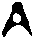

1/1 [==============================] - 0s 26ms/step
Predicted Character 19_10: A


1/1 [==============================] - 0s 30ms/step
Predicted Character 19_11: L


1/1 [==============================] - 0s 27ms/step
Predicted Character 19_12: F


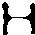

1/1 [==============================] - 0s 27ms/step
Predicted Character 19_13: H


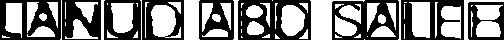

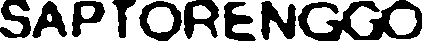

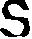

1/1 [==============================] - 0s 26ms/step
Predicted Character 20_1: S


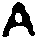

1/1 [==============================] - 0s 26ms/step
Predicted Character 20_2: A


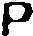

1/1 [==============================] - 0s 28ms/step
Predicted Character 20_3: P


1/1 [==============================] - 0s 26ms/step
Predicted Character 20_4: T


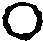

1/1 [==============================] - 0s 26ms/step
Predicted Character 20_5: O


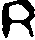

1/1 [==============================] - 0s 26ms/step
Predicted Character 20_6: R


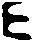

1/1 [==============================] - 0s 27ms/step
Predicted Character 20_7: L


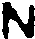

1/1 [==============================] - 0s 27ms/step
Predicted Character 20_8: N


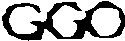

1/1 [==============================] - 0s 34ms/step
Predicted Character 20_9: W


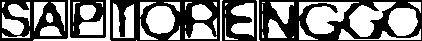

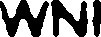

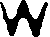

1/1 [==============================] - 0s 37ms/step
Predicted Character 21_1: W


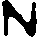

1/1 [==============================] - 0s 40ms/step
Predicted Character 21_2: N


1/1 [==============================] - 0s 45ms/step
Predicted Character 21_3: I


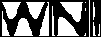

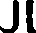

1/1 [==============================] - 0s 45ms/step
Predicted Character 22_1: J


1/1 [==============================] - 0s 40ms/step
Predicted Character 22_2: L


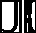

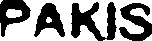

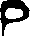

1/1 [==============================] - 0s 40ms/step
Predicted Character 23_1: P


1/1 [==============================] - 0s 49ms/step
Predicted Character 23_2: A


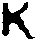

1/1 [==============================] - 0s 43ms/step
Predicted Character 23_3: K


1/1 [==============================] - 0s 39ms/step
Predicted Character 23_4: 3


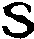

1/1 [==============================] - 0s 48ms/step
Predicted Character 23_5: S


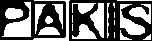

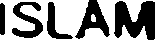

1/1 [==============================] - 0s 37ms/step
Predicted Character 24_1: T


1/1 [==============================] - 0s 38ms/step
Predicted Character 24_2: S


1/1 [==============================] - 0s 39ms/step
Predicted Character 24_3: L


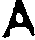

1/1 [==============================] - 0s 44ms/step
Predicted Character 24_4: A


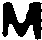

1/1 [==============================] - 0s 46ms/step
Predicted Character 24_5: M


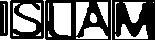

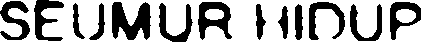

1/1 [==============================] - 0s 39ms/step
Predicted Character 25_1: R


1/1 [==============================] - 0s 39ms/step
Predicted Character 25_2: E


1/1 [==============================] - 0s 40ms/step
Predicted Character 25_3: L


1/1 [==============================] - 0s 47ms/step
Predicted Character 25_4: J


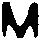

1/1 [==============================] - 0s 41ms/step
Predicted Character 25_5: M


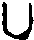

1/1 [==============================] - 0s 40ms/step
Predicted Character 25_6: U


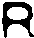

1/1 [==============================] - 0s 39ms/step
Predicted Character 25_7: R


1/1 [==============================] - 0s 40ms/step
Predicted Character 25_8: Y


1/1 [==============================] - 0s 41ms/step
Predicted Character 25_9: 9


1/1 [==============================] - 0s 41ms/step
Predicted Character 25_10: I


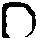

1/1 [==============================] - 0s 55ms/step
Predicted Character 25_11: D


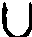

1/1 [==============================] - 0s 54ms/step
Predicted Character 25_12: U


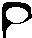

1/1 [==============================] - 0s 44ms/step
Predicted Character 25_13: P


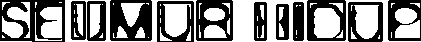

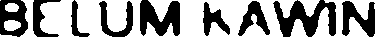

1/1 [==============================] - 0s 41ms/step
Predicted Character 26_1: 3


1/1 [==============================] - 0s 40ms/step
Predicted Character 26_2: L


1/1 [==============================] - 0s 38ms/step
Predicted Character 26_3: L


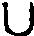

1/1 [==============================] - 0s 41ms/step
Predicted Character 26_4: U


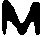

1/1 [==============================] - 0s 46ms/step
Predicted Character 26_5: M


1/1 [==============================] - 0s 44ms/step
Predicted Character 26_6: K


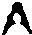

1/1 [==============================] - 0s 58ms/step
Predicted Character 26_7: A


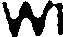

1/1 [==============================] - 0s 38ms/step
Predicted Character 26_8: W


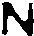

1/1 [==============================] - 0s 44ms/step
Predicted Character 26_9: N


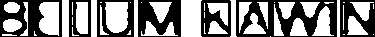

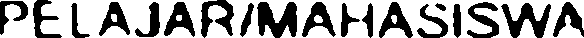

1/1 [==============================] - 0s 41ms/step
Predicted Character 27_1: P


1/1 [==============================] - 0s 39ms/step
Predicted Character 27_2: E


1/1 [==============================] - 0s 42ms/step
Predicted Character 27_3: L


1/1 [==============================] - 0s 40ms/step
Predicted Character 27_4: A


1/1 [==============================] - 0s 51ms/step
Predicted Character 27_5: J


1/1 [==============================] - 0s 41ms/step
Predicted Character 27_6: A


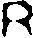

1/1 [==============================] - 0s 57ms/step
Predicted Character 27_7: P


1/1 [==============================] - 0s 43ms/step
Predicted Character 27_8: F


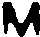

1/1 [==============================] - 0s 42ms/step
Predicted Character 27_9: M


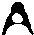

1/1 [==============================] - 0s 38ms/step
Predicted Character 27_10: A


1/1 [==============================] - 0s 38ms/step
Predicted Character 27_11: F


1/1 [==============================] - 0s 47ms/step
Predicted Character 27_12: 9


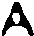

1/1 [==============================] - 0s 42ms/step
Predicted Character 27_13: A


1/1 [==============================] - 0s 41ms/step
Predicted Character 27_14: S


1/1 [==============================] - 0s 55ms/step
Predicted Character 27_15: 6


1/1 [==============================] - 0s 40ms/step
Predicted Character 27_16: I


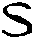

1/1 [==============================] - 0s 40ms/step
Predicted Character 27_17: S


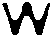

1/1 [==============================] - 0s 49ms/step
Predicted Character 27_18: W


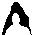

1/1 [==============================] - 0s 39ms/step
Predicted Character 27_19: A


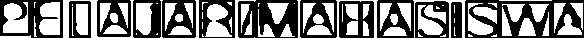

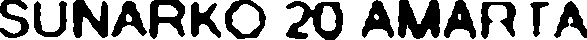

1/1 [==============================] - 0s 43ms/step
Predicted Character 28_1: 3


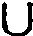

1/1 [==============================] - 0s 40ms/step
Predicted Character 28_2: U


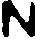

1/1 [==============================] - 0s 56ms/step
Predicted Character 28_3: N


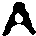

1/1 [==============================] - 0s 43ms/step
Predicted Character 28_4: A


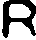

1/1 [==============================] - 0s 41ms/step
Predicted Character 28_5: B


1/1 [==============================] - 0s 39ms/step
Predicted Character 28_6: K


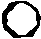

1/1 [==============================] - 0s 38ms/step
Predicted Character 28_7: Q


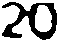

1/1 [==============================] - 0s 39ms/step
Predicted Character 28_8: N


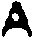

1/1 [==============================] - 0s 45ms/step
Predicted Character 28_9: A


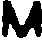

1/1 [==============================] - 0s 38ms/step
Predicted Character 28_10: M


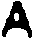

1/1 [==============================] - 0s 40ms/step
Predicted Character 28_11: A


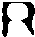

1/1 [==============================] - 0s 40ms/step
Predicted Character 28_12: H


1/1 [==============================] - 0s 40ms/step
Predicted Character 28_13: T


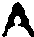

1/1 [==============================] - 0s 58ms/step
Predicted Character 28_14: A


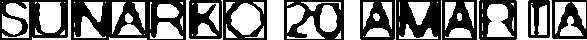

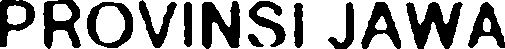

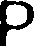

1/1 [==============================] - 0s 48ms/step
Predicted Character 29_1: P


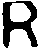

1/1 [==============================] - 0s 46ms/step
Predicted Character 29_2: H


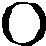

1/1 [==============================] - 0s 39ms/step
Predicted Character 29_3: O


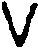

1/1 [==============================] - 0s 40ms/step
Predicted Character 29_4: V


1/1 [==============================] - 0s 42ms/step
Predicted Character 29_5: I


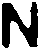

1/1 [==============================] - 0s 30ms/step
Predicted Character 29_6: N


1/1 [==============================] - 0s 31ms/step
Predicted Character 29_7: 1


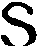

1/1 [==============================] - 0s 27ms/step
Predicted Character 29_8: S


1/1 [==============================] - 0s 29ms/step
Predicted Character 29_9: I


1/1 [==============================] - 0s 32ms/step
Predicted Character 29_10: J


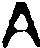

1/1 [==============================] - 0s 28ms/step
Predicted Character 29_11: A


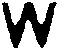

1/1 [==============================] - 0s 35ms/step
Predicted Character 29_12: W


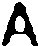

1/1 [==============================] - 0s 30ms/step
Predicted Character 29_13: A


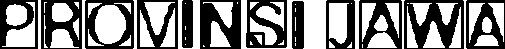

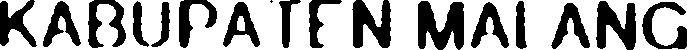

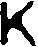

1/1 [==============================] - 0s 26ms/step
Predicted Character 30_1: K


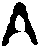

1/1 [==============================] - 0s 27ms/step
Predicted Character 30_2: A


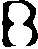

1/1 [==============================] - 0s 27ms/step
Predicted Character 30_3: B


1/1 [==============================] - 0s 27ms/step
Predicted Character 30_4: L


1/1 [==============================] - 0s 27ms/step
Predicted Character 30_5: J


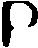

1/1 [==============================] - 0s 27ms/step
Predicted Character 30_6: P


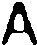

1/1 [==============================] - 0s 28ms/step
Predicted Character 30_7: A


1/1 [==============================] - 0s 26ms/step
Predicted Character 30_8: A


1/1 [==============================] - 0s 27ms/step
Predicted Character 30_9: V


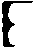

1/1 [==============================] - 0s 30ms/step
Predicted Character 30_10: F


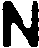

1/1 [==============================] - 0s 28ms/step
Predicted Character 30_11: N


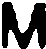

1/1 [==============================] - 0s 27ms/step
Predicted Character 30_12: M


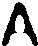

1/1 [==============================] - 0s 30ms/step
Predicted Character 30_13: A


1/1 [==============================] - 0s 28ms/step
Predicted Character 30_14: A


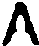

1/1 [==============================] - 0s 31ms/step
Predicted Character 30_15: A


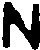

1/1 [==============================] - 0s 29ms/step
Predicted Character 30_16: N


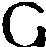

1/1 [==============================] - 0s 27ms/step
Predicted Character 30_17: G


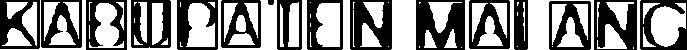

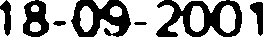

1/1 [==============================] - 0s 29ms/step
Predicted Character 31_1: 1


1/1 [==============================] - 0s 26ms/step
Predicted Character 31_2: 8


1/1 [==============================] - 0s 30ms/step
Predicted Character 31_3: 6


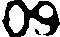

1/1 [==============================] - 0s 28ms/step
Predicted Character 31_4: W


1/1 [==============================] - 0s 29ms/step
Predicted Character 31_5: K


1/1 [==============================] - 0s 31ms/step
Predicted Character 31_6: L


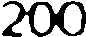

1/1 [==============================] - 0s 28ms/step
Predicted Character 31_7: M


1/1 [==============================] - 0s 30ms/step
Predicted Character 31_8: 1


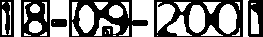

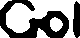

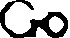

1/1 [==============================] - 0s 32ms/step
Predicted Character 32_1: J


1/1 [==============================] - 0s 26ms/step
Predicted Character 32_2: I


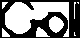

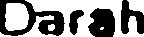

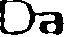

1/1 [==============================] - 0s 29ms/step
Predicted Character 33_1: N


1/1 [==============================] - 0s 27ms/step
Predicted Character 33_2: T


1/1 [==============================] - 0s 26ms/step
Predicted Character 33_3: 8


1/1 [==============================] - 0s 26ms/step
Predicted Character 33_4: H


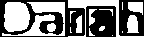

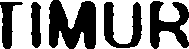

1/1 [==============================] - 0s 28ms/step
Predicted Character 34_1: F


1/1 [==============================] - 0s 27ms/step
Predicted Character 34_2: I


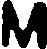

1/1 [==============================] - 0s 32ms/step
Predicted Character 34_3: M


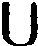

1/1 [==============================] - 0s 35ms/step
Predicted Character 34_4: U


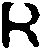

1/1 [==============================] - 0s 27ms/step
Predicted Character 34_5: R


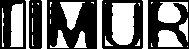

1/1 [==============================] - 0s 38ms/step
Predicted Character 35_1: 1


1/1 [==============================] - 0s 29ms/step
Predicted Character 35_2: 4


1/1 [==============================] - 0s 36ms/step
Predicted Character 35_3: 0


1/1 [==============================] - 0s 26ms/step
Predicted Character 35_4: A


1/1 [==============================] - 0s 34ms/step
Predicted Character 35_5: N


1/1 [==============================] - 0s 27ms/step
Predicted Character 35_6: 4


1/1 [==============================] - 0s 26ms/step
Predicted Character 35_7: L


1/1 [==============================] - 0s 26ms/step
Predicted Character 35_8: D


1/1 [==============================] - 0s 26ms/step
Predicted Character 35_9: 0


1/1 [==============================] - 0s 28ms/step
Predicted Character 35_10: N


1/1 [==============================] - 0s 28ms/step
Predicted Character 35_11: A


1/1 [==============================] - 0s 26ms/step
Predicted Character 35_12: 0


1/1 [==============================] - 0s 28ms/step
Predicted Character 36_1: M


1/1 [==============================] - 0s 34ms/step
Predicted Character 36_2: A


1/1 [==============================] - 0s 27ms/step
Predicted Character 36_3: M


1/1 [==============================] - 0s 28ms/step
Predicted Character 36_4: N


1/1 [==============================] - 0s 29ms/step
Predicted Character 36_5: G


1/1 [==============================] - 0s 26ms/step
Predicted Character 36_6: 1


In [ ]:
width, height = 100, 100

for idx, roi in enumerate(texts_roi):
    img_tmp = 255 - roi  # Invert colors
    kernel = np.array([
        [0, 1, 0],
        [1, 1, 1],
        [0, 1, 0]
    ], np.uint8)
    res = cv2.dilate(img_tmp, kernel, iterations=1)
    res = 255 - res
    cv2_imshow(res)
    cropped_img = texts_roi[idx]
    _, thresh = cv2.threshold(cropped_img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    ktp_contours = cropped_img.copy()
    contours = sorted(contours, key=lambda x: cv2.boundingRect(x)[0])

    for i, contour in enumerate(contours):
        x, y, w, h = cv2.boundingRect(contour)
        padding = 2
        x = max(0, x - padding)
        y = max(0, y - padding)
        w = min(cropped_img.shape[1], w + 1 * padding)
        h = min(cropped_img.shape[0], h + 1 * padding)

        digit_img = cropped_img[y:y+h, x:x+w]
        cv2_imshow(digit_img)

        cv2.rectangle(ktp_contours, (x, y), (x + w, y + h), (0, 255, 0), 2)

        digit_resized = cv2.resize(digit_img, (width, height))

        digit_resized = digit_resized.astype('float32') / 255.0
        digit_resized = np.expand_dims(digit_resized, axis=-1)
        digit_resized = np.expand_dims(digit_resized, axis=0)  # Add batch dimension
        prediction = model.predict(digit_resized)

        # Assuming you have a function to convert the model output to a character
        predicted_char = convert_to_char(prediction)

        # Display the predicted character
        print(f"Predicted Character {idx+1}_{i+1}: {predicted_char}")

    # Display the results for each ROI
    cv2_imshow(ktp_contours)


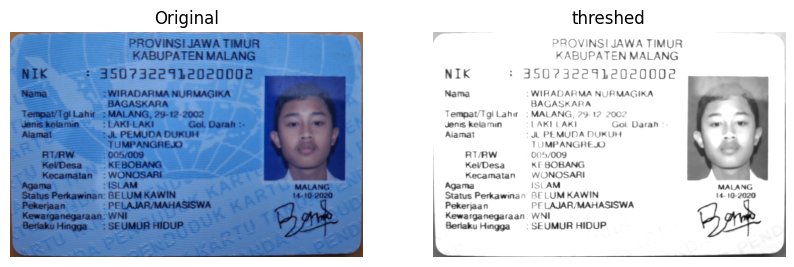

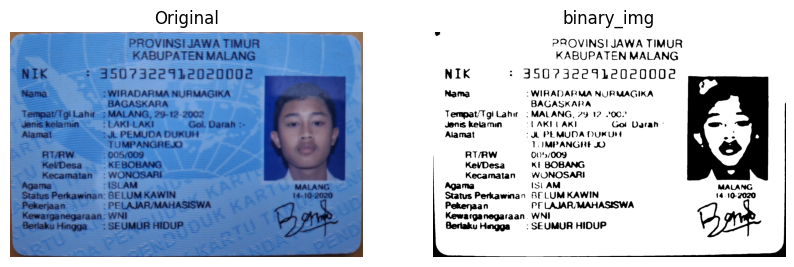

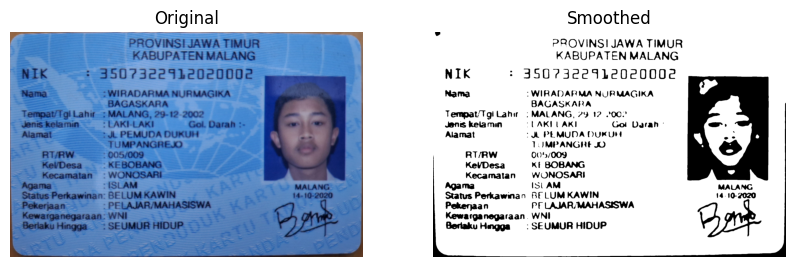

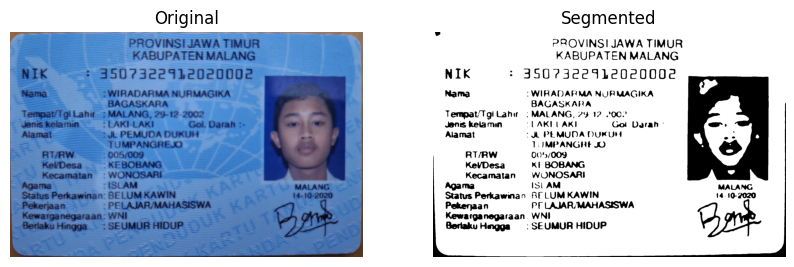

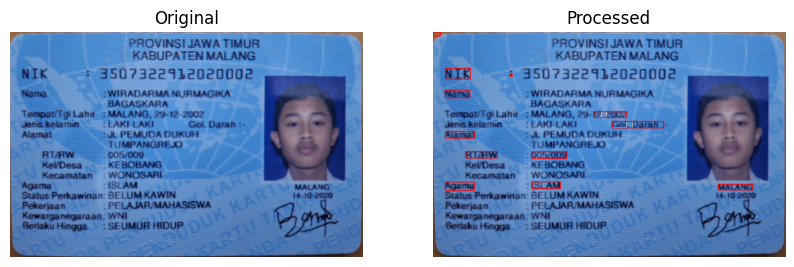

1/1 [==============================] - 0s 63ms/step
Predicted Character 1_1: V


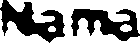

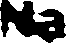

1/1 [==============================] - 0s 56ms/step
Predicted Character 2_1: N


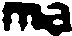

1/1 [==============================] - 0s 38ms/step
Predicted Character 2_2: N


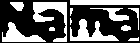

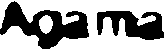

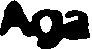

1/1 [==============================] - 0s 38ms/step
Predicted Character 3_1: Y


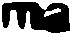

1/1 [==============================] - 0s 38ms/step
Predicted Character 3_2: N


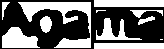

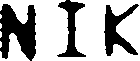

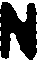

1/1 [==============================] - 0s 36ms/step
Predicted Character 4_1: N


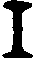

1/1 [==============================] - 0s 37ms/step
Predicted Character 4_2: I


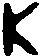

1/1 [==============================] - 0s 36ms/step
Predicted Character 4_3: K


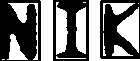

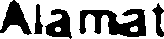

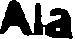

1/1 [==============================] - 0s 39ms/step
Predicted Character 5_1: N


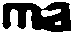

1/1 [==============================] - 0s 41ms/step
Predicted Character 5_2: N


1/1 [==============================] - 0s 38ms/step
Predicted Character 5_3: 1


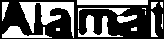

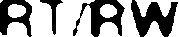

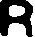

1/1 [==============================] - 0s 42ms/step
Predicted Character 6_1: R


1/1 [==============================] - 0s 41ms/step
Predicted Character 6_2: T


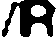

1/1 [==============================] - 0s 40ms/step
Predicted Character 6_3: M


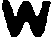

1/1 [==============================] - 0s 38ms/step
Predicted Character 6_4: W


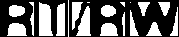

1/1 [==============================] - 0s 37ms/step
Predicted Character 7_1: M


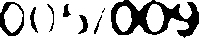

1/1 [==============================] - 0s 38ms/step
Predicted Character 8_1: O


1/1 [==============================] - 0s 55ms/step
Predicted Character 8_2: K


1/1 [==============================] - 0s 57ms/step
Predicted Character 8_3: D


1/1 [==============================] - 0s 74ms/step
Predicted Character 8_4: I


1/1 [==============================] - 0s 77ms/step
Predicted Character 8_5: 2


1/1 [==============================] - 0s 53ms/step
Predicted Character 8_6: 3


1/1 [==============================] - 0s 49ms/step
Predicted Character 8_7: X


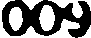

1/1 [==============================] - 0s 46ms/step
Predicted Character 8_8: W


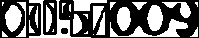

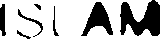

1/1 [==============================] - 0s 48ms/step
Predicted Character 9_1: X


1/1 [==============================] - 0s 37ms/step
Predicted Character 9_2: Z


1/1 [==============================] - 0s 38ms/step
Predicted Character 9_3: N


1/1 [==============================] - 0s 44ms/step
Predicted Character 9_4: L


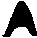

1/1 [==============================] - 0s 50ms/step
Predicted Character 9_5: A


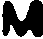

1/1 [==============================] - 0s 59ms/step
Predicted Character 9_6: M


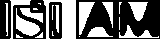

1/1 [==============================] - 0s 82ms/step
Predicted Character 10_1: T


1/1 [==============================] - 0s 55ms/step
Predicted Character 10_2: P


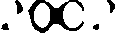

1/1 [==============================] - 0s 55ms/step
Predicted Character 11_1: 6


1/1 [==============================] - 0s 58ms/step
Predicted Character 11_2: V


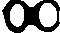

1/1 [==============================] - 0s 67ms/step
Predicted Character 11_3: K


1/1 [==============================] - 0s 67ms/step
Predicted Character 11_4: 4


1/1 [==============================] - 0s 52ms/step
Predicted Character 11_5: R


1/1 [==============================] - 0s 53ms/step
Predicted Character 11_6: J


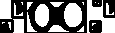

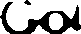

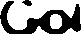

1/1 [==============================] - 0s 52ms/step
Predicted Character 12_1: H


1/1 [==============================] - 0s 57ms/step
Predicted Character 12_2: 9


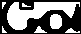

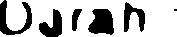

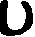

1/1 [==============================] - 0s 49ms/step
Predicted Character 13_1: D


1/1 [==============================] - 0s 60ms/step
Predicted Character 13_2: A


1/1 [==============================] - 0s 58ms/step
Predicted Character 13_3: C


1/1 [==============================] - 0s 57ms/step
Predicted Character 13_4: 1


1/1 [==============================] - 0s 57ms/step
Predicted Character 13_5: N


1/1 [==============================] - 0s 51ms/step
Predicted Character 13_6: 4


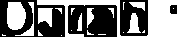

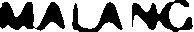

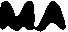

1/1 [==============================] - 0s 38ms/step
Predicted Character 14_1: M


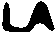

1/1 [==============================] - 0s 78ms/step
Predicted Character 14_2: M


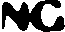

1/1 [==============================] - 0s 56ms/step
Predicted Character 14_3: K


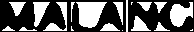

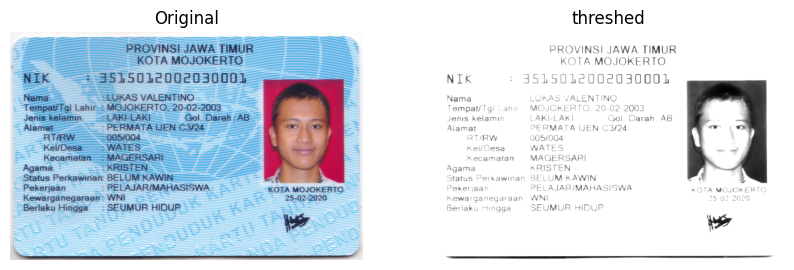

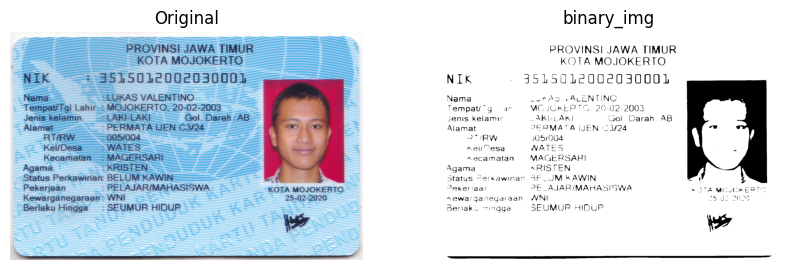

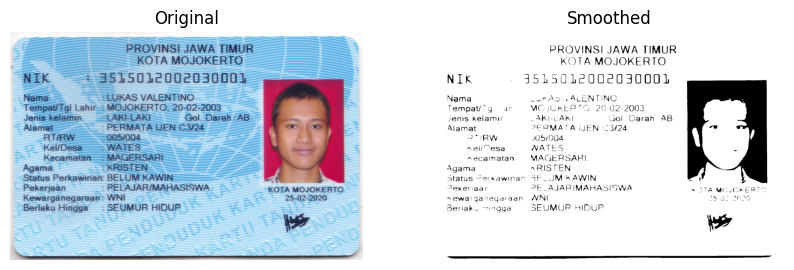

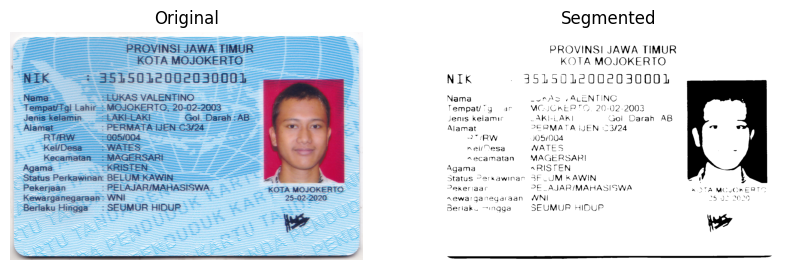

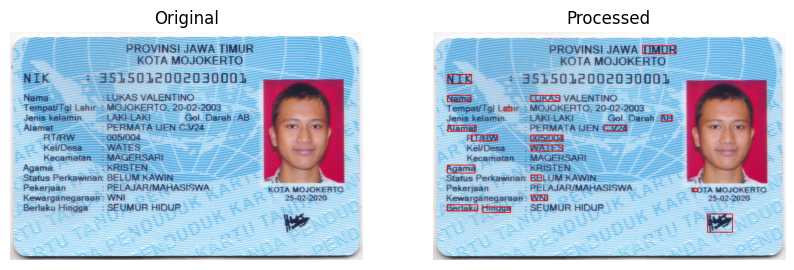

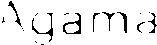

1/1 [==============================] - 0s 43ms/step
Predicted Character 1_1: A


1/1 [==============================] - 0s 39ms/step
Predicted Character 1_2: G


1/1 [==============================] - 0s 42ms/step
Predicted Character 1_3: 8


1/1 [==============================] - 0s 38ms/step
Predicted Character 1_4: N


1/1 [==============================] - 0s 47ms/step
Predicted Character 1_5: 8


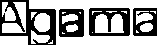

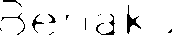

1/1 [==============================] - 0s 41ms/step
Predicted Character 2_1: B


1/1 [==============================] - 0s 47ms/step
Predicted Character 2_2: R


1/1 [==============================] - 0s 40ms/step
Predicted Character 2_3: F


1/1 [==============================] - 0s 40ms/step
Predicted Character 2_4: I


1/1 [==============================] - 0s 43ms/step
Predicted Character 2_5: 8


1/1 [==============================] - 0s 46ms/step
Predicted Character 2_6: W


1/1 [==============================] - 0s 41ms/step
Predicted Character 2_7: L


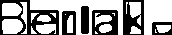

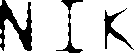

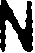

1/1 [==============================] - 0s 36ms/step
Predicted Character 3_1: N


1/1 [==============================] - 0s 36ms/step
Predicted Character 3_2: 1


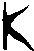

1/1 [==============================] - 0s 40ms/step
Predicted Character 3_3: K


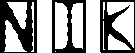

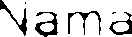

1/1 [==============================] - 0s 43ms/step
Predicted Character 4_1: 1


1/1 [==============================] - 0s 41ms/step
Predicted Character 4_2: 8


1/1 [==============================] - 0s 39ms/step
Predicted Character 4_3: N


1/1 [==============================] - 0s 37ms/step
Predicted Character 4_4: E


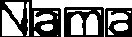

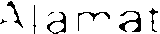

1/1 [==============================] - 0s 49ms/step
Predicted Character 5_1: A


1/1 [==============================] - 0s 40ms/step
Predicted Character 5_2: 1


1/1 [==============================] - 0s 41ms/step
Predicted Character 5_3: 8


1/1 [==============================] - 0s 37ms/step
Predicted Character 5_4: N


1/1 [==============================] - 0s 42ms/step
Predicted Character 5_5: 8


1/1 [==============================] - 0s 58ms/step
Predicted Character 5_6: 1


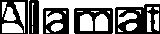

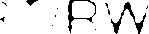

1/1 [==============================] - 0s 38ms/step
Predicted Character 6_1: Y


1/1 [==============================] - 0s 39ms/step
Predicted Character 6_2: N


1/1 [==============================] - 0s 39ms/step
Predicted Character 6_3: Y


1/1 [==============================] - 0s 38ms/step
Predicted Character 6_4: L


1/1 [==============================] - 0s 41ms/step
Predicted Character 6_5: 4


1/1 [==============================] - 0s 41ms/step
Predicted Character 6_6: Y


1/1 [==============================] - 0s 41ms/step
Predicted Character 6_7: 4


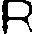

1/1 [==============================] - 0s 40ms/step
Predicted Character 6_8: F


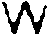

1/1 [==============================] - 0s 38ms/step
Predicted Character 6_9: W


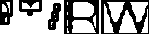

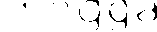

1/1 [==============================] - 0s 39ms/step
Predicted Character 7_1: H


1/1 [==============================] - 0s 39ms/step
Predicted Character 7_2: 1


1/1 [==============================] - 0s 39ms/step
Predicted Character 7_3: F


1/1 [==============================] - 0s 42ms/step
Predicted Character 7_4: D


1/1 [==============================] - 0s 41ms/step
Predicted Character 7_5: G


1/1 [==============================] - 0s 41ms/step
Predicted Character 7_6: 2


1/1 [==============================] - 0s 39ms/step
Predicted Character 7_7: G


1/1 [==============================] - 0s 45ms/step
Predicted Character 7_8: L


1/1 [==============================] - 0s 44ms/step
Predicted Character 7_9: 6


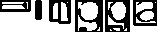

1/1 [==============================] - 0s 42ms/step
Predicted Character 8_1: L


1/1 [==============================] - 0s 48ms/step
Predicted Character 8_2: A


1/1 [==============================] - 0s 47ms/step
Predicted Character 8_3: C


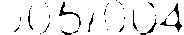

1/1 [==============================] - 0s 40ms/step
Predicted Character 9_1: H


1/1 [==============================] - 0s 40ms/step
Predicted Character 9_2: A


1/1 [==============================] - 0s 39ms/step
Predicted Character 9_3: J


1/1 [==============================] - 0s 49ms/step
Predicted Character 9_4: L


1/1 [==============================] - 0s 65ms/step
Predicted Character 9_5: L


1/1 [==============================] - 0s 63ms/step
Predicted Character 9_6: G


1/1 [==============================] - 0s 54ms/step
Predicted Character 9_7: L


1/1 [==============================] - 0s 46ms/step
Predicted Character 9_8: D


1/1 [==============================] - 0s 75ms/step
Predicted Character 9_9: 3


1/1 [==============================] - 0s 54ms/step
Predicted Character 9_10: T


1/1 [==============================] - 0s 50ms/step
Predicted Character 9_11: U


1/1 [==============================] - 0s 60ms/step
Predicted Character 9_12: C


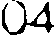

1/1 [==============================] - 0s 83ms/step
Predicted Character 9_13: N


1/1 [==============================] - 0s 42ms/step
Predicted Character 9_14: T


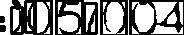

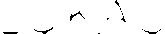

1/1 [==============================] - 0s 47ms/step
Predicted Character 10_1: 6


1/1 [==============================] - 0s 78ms/step
Predicted Character 10_2: J


1/1 [==============================] - 0s 37ms/step
Predicted Character 10_3: 4


1/1 [==============================] - 0s 38ms/step
Predicted Character 10_4: 6


1/1 [==============================] - 0s 71ms/step
Predicted Character 10_5: A


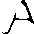

1/1 [==============================] - 0s 39ms/step
Predicted Character 10_6: B


1/1 [==============================] - 0s 52ms/step
Predicted Character 10_7: W


1/1 [==============================] - 0s 59ms/step
Predicted Character 10_8: 8


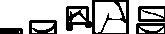

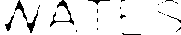

1/1 [==============================] - 0s 42ms/step
Predicted Character 11_1: L


1/1 [==============================] - 0s 60ms/step
Predicted Character 11_2: A


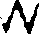

1/1 [==============================] - 0s 62ms/step
Predicted Character 11_3: N


1/1 [==============================] - 0s 68ms/step
Predicted Character 11_4: 4


1/1 [==============================] - 0s 47ms/step
Predicted Character 11_5: 4


1/1 [==============================] - 0s 58ms/step
Predicted Character 11_6: T


1/1 [==============================] - 0s 42ms/step
Predicted Character 11_7: H


1/1 [==============================] - 0s 76ms/step
Predicted Character 11_8: L


1/1 [==============================] - 0s 47ms/step
Predicted Character 11_9: K


1/1 [==============================] - 0s 45ms/step
Predicted Character 11_10: 1


1/1 [==============================] - 0s 71ms/step
Predicted Character 11_11: O


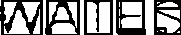

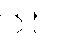

1/1 [==============================] - 0s 42ms/step
Predicted Character 12_1: B


1/1 [==============================] - 0s 84ms/step
Predicted Character 12_2: H


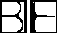

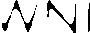

1/1 [==============================] - 0s 57ms/step
Predicted Character 13_1: H


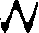

1/1 [==============================] - 0s 61ms/step
Predicted Character 13_2: N


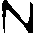

1/1 [==============================] - 0s 42ms/step
Predicted Character 13_3: N


1/1 [==============================] - 0s 64ms/step
Predicted Character 13_4: I


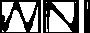

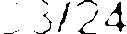

1/1 [==============================] - 0s 46ms/step
Predicted Character 14_1: J


1/1 [==============================] - 0s 41ms/step
Predicted Character 14_2: D


1/1 [==============================] - 0s 75ms/step
Predicted Character 14_3: 4


1/1 [==============================] - 0s 62ms/step
Predicted Character 14_4: 3


1/1 [==============================] - 0s 41ms/step
Predicted Character 14_5: X


1/1 [==============================] - 0s 44ms/step
Predicted Character 14_6: Z


1/1 [==============================] - 0s 55ms/step
Predicted Character 14_7: 4


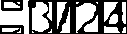

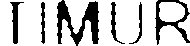

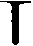

1/1 [==============================] - 0s 58ms/step
Predicted Character 15_1: T


1/1 [==============================] - 0s 52ms/step
Predicted Character 15_2: I


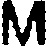

1/1 [==============================] - 0s 79ms/step
Predicted Character 15_3: M


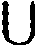

1/1 [==============================] - 0s 60ms/step
Predicted Character 15_4: U


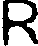

1/1 [==============================] - 0s 56ms/step
Predicted Character 15_5: F


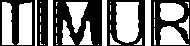

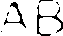

1/1 [==============================] - 0s 63ms/step
Predicted Character 16_1: H


1/1 [==============================] - 0s 64ms/step
Predicted Character 16_2: A


1/1 [==============================] - 0s 63ms/step
Predicted Character 16_3: B


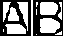

1/1 [==============================] - 0s 50ms/step
Predicted Character 17_1: K


1/1 [==============================] - 0s 75ms/step
Predicted Character 17_2: Y


1/1 [==============================] - 0s 55ms/step
Predicted Character 17_3: L


1/1 [==============================] - 0s 62ms/step
Predicted Character 17_4: 2


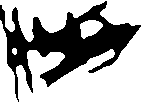

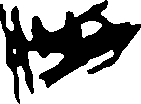

1/1 [==============================] - 0s 61ms/step
Predicted Character 18_1: P


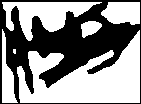

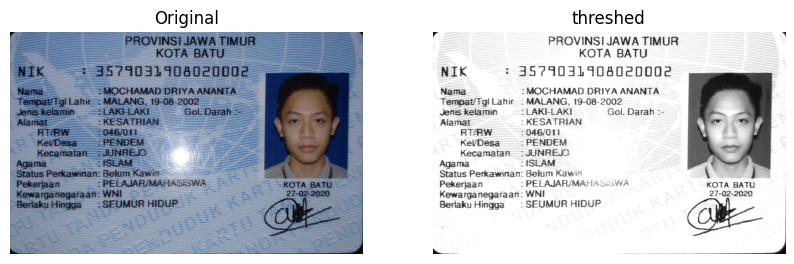

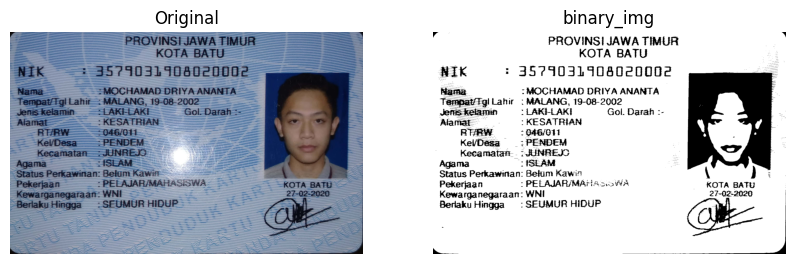

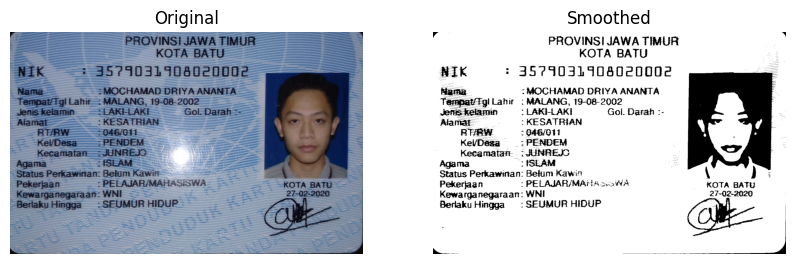

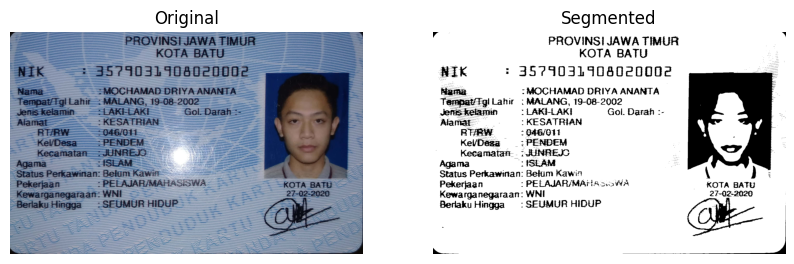

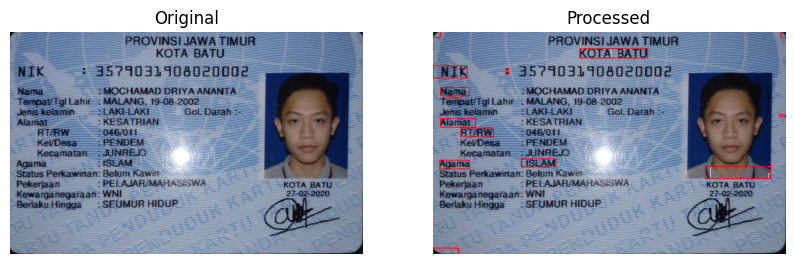

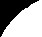

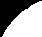

1/1 [==============================] - 0s 53ms/step
Predicted Character 1_1: K


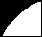

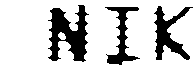

1/1 [==============================] - 0s 47ms/step
Predicted Character 2_1: 2


1/1 [==============================] - 0s 58ms/step
Predicted Character 2_2: 2


1/1 [==============================] - 0s 54ms/step
Predicted Character 2_3: L


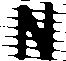

1/1 [==============================] - 0s 59ms/step
Predicted Character 2_4: R


1/1 [==============================] - 0s 54ms/step
Predicted Character 2_5: 2


1/1 [==============================] - 0s 65ms/step
Predicted Character 2_6: L


1/1 [==============================] - 0s 69ms/step
Predicted Character 2_7: L


1/1 [==============================] - 0s 81ms/step
Predicted Character 2_8: L


1/1 [==============================] - 0s 64ms/step
Predicted Character 2_9: L


1/1 [==============================] - 0s 55ms/step
Predicted Character 2_10: 2


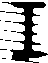

1/1 [==============================] - 0s 67ms/step
Predicted Character 2_11: Z


1/1 [==============================] - 0s 71ms/step
Predicted Character 2_12: 2


1/1 [==============================] - 0s 70ms/step
Predicted Character 2_13: 2


1/1 [==============================] - 0s 46ms/step
Predicted Character 2_14: 2


1/1 [==============================] - 0s 68ms/step
Predicted Character 2_15: 2


1/1 [==============================] - 0s 62ms/step
Predicted Character 2_16: T


1/1 [==============================] - 0s 55ms/step
Predicted Character 2_17: 2


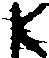

1/1 [==============================] - 0s 44ms/step
Predicted Character 2_18: K


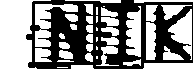

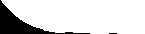

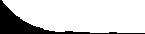

1/1 [==============================] - 0s 63ms/step
Predicted Character 3_1: L


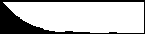

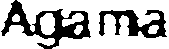

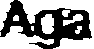

1/1 [==============================] - 0s 68ms/step
Predicted Character 4_1: V


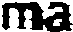

1/1 [==============================] - 0s 60ms/step
Predicted Character 4_2: N


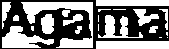

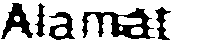

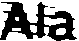

1/1 [==============================] - 0s 66ms/step
Predicted Character 5_1: N


1/1 [==============================] - 0s 55ms/step
Predicted Character 5_2: 2


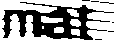

1/1 [==============================] - 0s 62ms/step
Predicted Character 5_3: W


1/1 [==============================] - 0s 52ms/step
Predicted Character 5_4: A


1/1 [==============================] - 0s 69ms/step
Predicted Character 5_5: T


1/1 [==============================] - 0s 50ms/step
Predicted Character 5_6: Y


1/1 [==============================] - 0s 66ms/step
Predicted Character 5_7: L


1/1 [==============================] - 0s 58ms/step
Predicted Character 5_8: K


1/1 [==============================] - 0s 59ms/step
Predicted Character 5_9: K


1/1 [==============================] - 0s 78ms/step
Predicted Character 5_10: L


1/1 [==============================] - 0s 67ms/step
Predicted Character 5_11: 2


1/1 [==============================] - 0s 62ms/step
Predicted Character 5_12: 2


1/1 [==============================] - 0s 62ms/step
Predicted Character 5_13: 2


1/1 [==============================] - 0s 51ms/step
Predicted Character 5_14: 2


1/1 [==============================] - 0s 64ms/step
Predicted Character 5_15: L


1/1 [==============================] - 0s 51ms/step
Predicted Character 5_16: 2


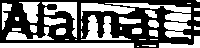

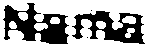

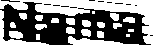

1/1 [==============================] - 0s 63ms/step
Predicted Character 6_1: W


1/1 [==============================] - 0s 52ms/step
Predicted Character 6_2: P


1/1 [==============================] - 0s 56ms/step
Predicted Character 6_3: 2


1/1 [==============================] - 0s 42ms/step
Predicted Character 6_4: 2


1/1 [==============================] - 0s 69ms/step
Predicted Character 6_5: L


1/1 [==============================] - 0s 66ms/step
Predicted Character 6_6: L


1/1 [==============================] - 0s 45ms/step
Predicted Character 6_7: K


1/1 [==============================] - 0s 81ms/step
Predicted Character 6_8: T


1/1 [==============================] - 0s 50ms/step
Predicted Character 6_9: Y


1/1 [==============================] - 0s 48ms/step
Predicted Character 6_10: 2


1/1 [==============================] - 0s 40ms/step
Predicted Character 6_11: L


1/1 [==============================] - 0s 37ms/step
Predicted Character 6_12: 2


1/1 [==============================] - 0s 37ms/step
Predicted Character 6_13: 2


1/1 [==============================] - 0s 63ms/step
Predicted Character 6_14: 2


1/1 [==============================] - 0s 76ms/step
Predicted Character 6_15: 2


1/1 [==============================] - 0s 39ms/step
Predicted Character 6_16: L


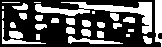

1/1 [==============================] - 0s 63ms/step
Predicted Character 7_1: N


1/1 [==============================] - 0s 50ms/step
Predicted Character 7_2: 2


1/1 [==============================] - 0s 54ms/step
Predicted Character 7_3: P


1/1 [==============================] - 0s 45ms/step
Predicted Character 7_4: L


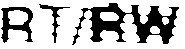

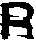

1/1 [==============================] - 0s 47ms/step
Predicted Character 8_1: R


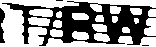

1/1 [==============================] - 0s 61ms/step
Predicted Character 8_2: W


1/1 [==============================] - 0s 49ms/step
Predicted Character 8_3: 2


1/1 [==============================] - 0s 61ms/step
Predicted Character 8_4: T


1/1 [==============================] - 0s 46ms/step
Predicted Character 8_5: L


1/1 [==============================] - 0s 48ms/step
Predicted Character 8_6: 2


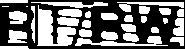

1/1 [==============================] - 0s 44ms/step
Predicted Character 9_1: V


1/1 [==============================] - 0s 44ms/step
Predicted Character 10_1: J


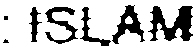

1/1 [==============================] - 0s 43ms/step
Predicted Character 11_1: 6


1/1 [==============================] - 0s 40ms/step
Predicted Character 11_2: Y


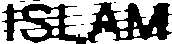

1/1 [==============================] - 0s 63ms/step
Predicted Character 11_3: N


1/1 [==============================] - 0s 84ms/step
Predicted Character 11_4: 2


1/1 [==============================] - 0s 73ms/step
Predicted Character 11_5: 2


1/1 [==============================] - 0s 72ms/step
Predicted Character 11_6: Y


1/1 [==============================] - 0s 56ms/step
Predicted Character 11_7: T


1/1 [==============================] - 0s 87ms/step
Predicted Character 11_8: L


1/1 [==============================] - 0s 59ms/step
Predicted Character 11_9: 2


1/1 [==============================] - 0s 54ms/step
Predicted Character 11_10: 2


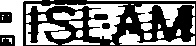

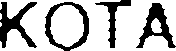

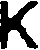

1/1 [==============================] - 0s 72ms/step
Predicted Character 12_1: K


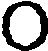

1/1 [==============================] - 0s 62ms/step
Predicted Character 12_2: O


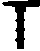

1/1 [==============================] - 0s 72ms/step
Predicted Character 12_3: T


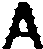

1/1 [==============================] - 0s 38ms/step
Predicted Character 12_4: A


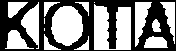

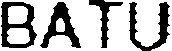

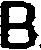

1/1 [==============================] - 0s 44ms/step
Predicted Character 13_1: 3


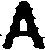

1/1 [==============================] - 0s 44ms/step
Predicted Character 13_2: A


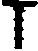

1/1 [==============================] - 0s 53ms/step
Predicted Character 13_3: T


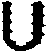

1/1 [==============================] - 0s 40ms/step
Predicted Character 13_4: U


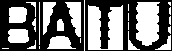

1/1 [==============================] - 0s 45ms/step
Predicted Character 14_1: K


1/1 [==============================] - 0s 42ms/step
Predicted Character 15_1: K


1/1 [==============================] - 0s 41ms/step
Predicted Character 15_2: Y


1/1 [==============================] - 0s 46ms/step
Predicted Character 15_3: K


1/1 [==============================] - 0s 43ms/step
Predicted Character 15_4: A


1/1 [==============================] - 0s 47ms/step
Predicted Character 16_1: Y


1/1 [==============================] - 0s 63ms/step
Predicted Character 16_2: 2


1/1 [==============================] - 0s 38ms/step
Predicted Character 16_3: 2


1/1 [==============================] - 0s 46ms/step
Predicted Character 16_4: 2


1/1 [==============================] - 0s 41ms/step
Predicted Character 17_1: B


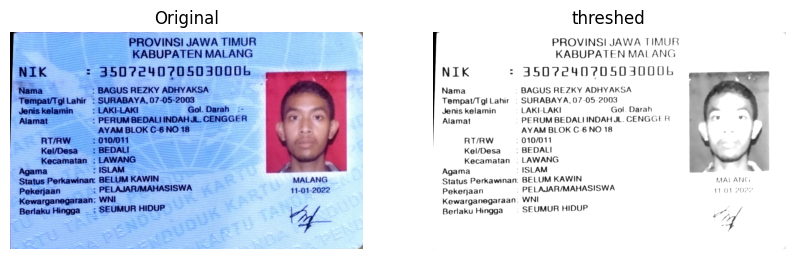

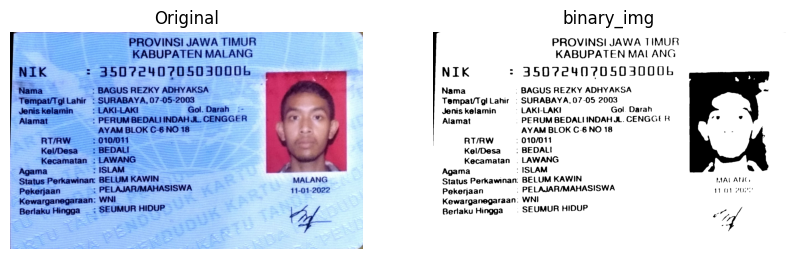

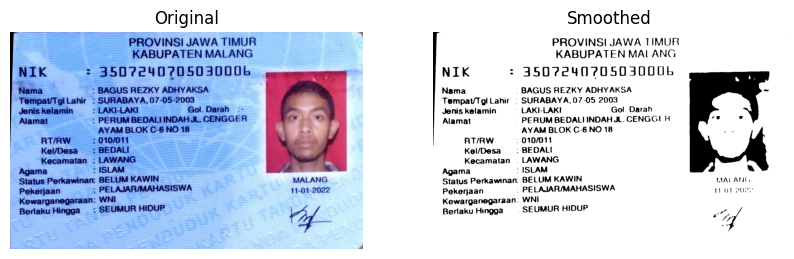

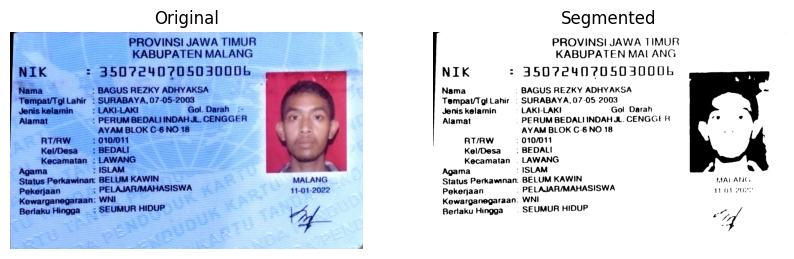

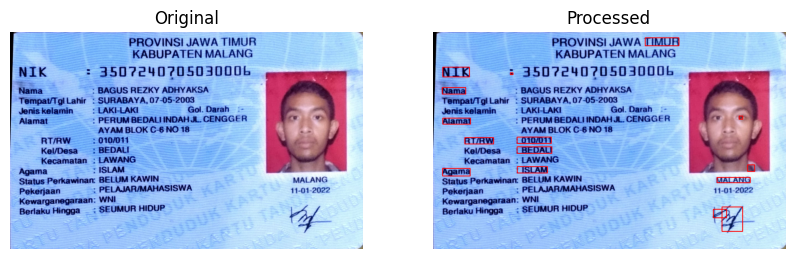

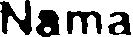

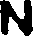

1/1 [==============================] - 0s 58ms/step
Predicted Character 1_1: N


1/1 [==============================] - 0s 79ms/step
Predicted Character 1_2: 8


1/1 [==============================] - 0s 53ms/step
Predicted Character 1_3: M


1/1 [==============================] - 0s 49ms/step
Predicted Character 1_4: 3


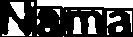

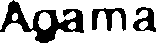

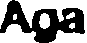

1/1 [==============================] - 0s 66ms/step
Predicted Character 2_1: M


1/1 [==============================] - 0s 58ms/step
Predicted Character 2_2: M


1/1 [==============================] - 0s 51ms/step
Predicted Character 2_3: 8


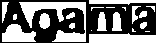

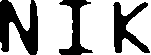

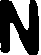

1/1 [==============================] - 0s 55ms/step
Predicted Character 3_1: N


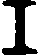

1/1 [==============================] - 0s 82ms/step
Predicted Character 3_2: I


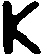

1/1 [==============================] - 0s 75ms/step
Predicted Character 3_3: K


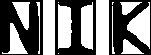

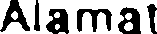

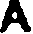

1/1 [==============================] - 0s 44ms/step
Predicted Character 4_1: A


1/1 [==============================] - 0s 58ms/step
Predicted Character 4_2: I


1/1 [==============================] - 0s 37ms/step
Predicted Character 4_3: 8


1/1 [==============================] - 0s 71ms/step
Predicted Character 4_4: M


1/1 [==============================] - 0s 77ms/step
Predicted Character 4_5: 8


1/1 [==============================] - 0s 75ms/step
Predicted Character 4_6: 1


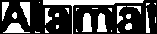

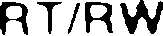

1/1 [==============================] - 0s 46ms/step
Predicted Character 5_1: R


1/1 [==============================] - 0s 39ms/step
Predicted Character 5_2: T


1/1 [==============================] - 0s 73ms/step
Predicted Character 5_3: Z


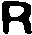

1/1 [==============================] - 0s 61ms/step
Predicted Character 5_4: R


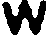

1/1 [==============================] - 0s 65ms/step
Predicted Character 5_5: W


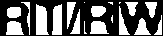

1/1 [==============================] - 0s 79ms/step
Predicted Character 6_1: U


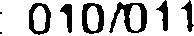

1/1 [==============================] - 0s 55ms/step
Predicted Character 7_1: 6


1/1 [==============================] - 0s 57ms/step
Predicted Character 7_2: 6


1/1 [==============================] - 0s 80ms/step
Predicted Character 7_3: 0


1/1 [==============================] - 0s 66ms/step
Predicted Character 7_4: 1


1/1 [==============================] - 0s 70ms/step
Predicted Character 7_5: C


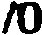

1/1 [==============================] - 0s 50ms/step
Predicted Character 7_6: N


1/1 [==============================] - 0s 76ms/step
Predicted Character 7_7: 1


1/1 [==============================] - 0s 64ms/step
Predicted Character 7_8: 1


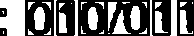

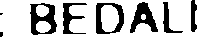

1/1 [==============================] - 0s 62ms/step
Predicted Character 8_1: W


1/1 [==============================] - 0s 76ms/step
Predicted Character 8_2: F


1/1 [==============================] - 0s 57ms/step
Predicted Character 8_3: B


1/1 [==============================] - 0s 69ms/step
Predicted Character 8_4: E


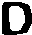

1/1 [==============================] - 0s 47ms/step
Predicted Character 8_5: D


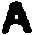

1/1 [==============================] - 0s 61ms/step
Predicted Character 8_6: A


1/1 [==============================] - 0s 63ms/step
Predicted Character 8_7: L


1/1 [==============================] - 0s 64ms/step
Predicted Character 8_8: I


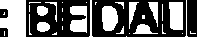

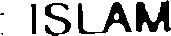

1/1 [==============================] - 0s 64ms/step
Predicted Character 9_1: W


1/1 [==============================] - 0s 51ms/step
Predicted Character 9_2: 6


1/1 [==============================] - 0s 48ms/step
Predicted Character 9_3: 1


1/1 [==============================] - 0s 45ms/step
Predicted Character 9_4: S


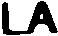

1/1 [==============================] - 0s 56ms/step
Predicted Character 9_5: M


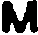

1/1 [==============================] - 0s 64ms/step
Predicted Character 9_6: M


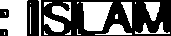

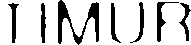

1/1 [==============================] - 0s 50ms/step
Predicted Character 10_1: J


1/1 [==============================] - 0s 64ms/step
Predicted Character 10_2: I


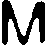

1/1 [==============================] - 0s 74ms/step
Predicted Character 10_3: M


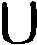

1/1 [==============================] - 0s 40ms/step
Predicted Character 10_4: U


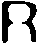

1/1 [==============================] - 0s 53ms/step
Predicted Character 10_5: B


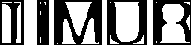

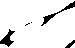

1/1 [==============================] - 0s 48ms/step
Predicted Character 11_1: J


1/1 [==============================] - 0s 37ms/step
Predicted Character 11_2: V


1/1 [==============================] - 0s 38ms/step
Predicted Character 11_3: Y


1/1 [==============================] - 0s 39ms/step
Predicted Character 11_4: J


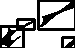

1/1 [==============================] - 0s 39ms/step
Predicted Character 12_1: N


1/1 [==============================] - 0s 39ms/step
Predicted Character 12_2: 6


1/1 [==============================] - 0s 40ms/step
Predicted Character 12_3: 1


1/1 [==============================] - 0s 38ms/step
Predicted Character 12_4: A


1/1 [==============================] - 0s 38ms/step
Predicted Character 12_5: 1


1/1 [==============================] - 0s 39ms/step
Predicted Character 12_6: A


1/1 [==============================] - 0s 39ms/step
Predicted Character 12_7: C


1/1 [==============================] - 0s 37ms/step
Predicted Character 12_8: J


1/1 [==============================] - 0s 40ms/step
Predicted Character 12_9: K


1/1 [==============================] - 0s 39ms/step
Predicted Character 12_10: 1


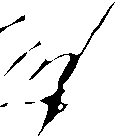

1/1 [==============================] - 0s 39ms/step
Predicted Character 13_1: Y


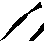

1/1 [==============================] - 0s 41ms/step
Predicted Character 13_2: A


1/1 [==============================] - 0s 36ms/step
Predicted Character 13_3: 8


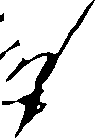

1/1 [==============================] - 0s 41ms/step
Predicted Character 13_4: V


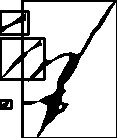

1/1 [==============================] - 0s 38ms/step
Predicted Character 14_1: I


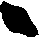

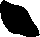

1/1 [==============================] - 0s 50ms/step
Predicted Character 15_1: 6


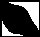

In [ ]:
def preprocess_and_predict(image_path, model, width=100, height=100):
    ktp_image = load_image(image_path)
    original_height, original_width = ktp_image.shape[:2]

    # Calculate the new dimensions while preserving the aspect ratio
    desired_width = 2000
    aspect_ratio = original_width / original_height
    desired_height = int(desired_width / aspect_ratio)

    # Resize the image
    resized_image = cv2.resize(ktp_image, (desired_width, desired_height))

    ktp_denoised = cv2.fastNlMeansDenoisingColored(resized_image, None, h=7)
    ktp_image_gray = cv2.cvtColor(ktp_denoised, cv2.COLOR_BGR2GRAY)
    ret, threshed = cv2.threshold(ktp_image_gray, 127, 255, cv2.THRESH_TRUNC)

    compare_images(ktp_image, threshed, title_after='threshed', cmap='gray')
    _, binary_img = cv2.threshold(threshed, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    compare_images(ktp_image, binary_img, title_after='binary_img', cmap='gray')

    kernel = np.ones((3,2), np.uint8)
    smoothed_img = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, kernel)
    compare_images(ktp_image, smoothed_img, title_after='Smoothed', cmap='gray')

    _, segmented_img = cv2.threshold(smoothed_img, 1, 255, cv2.THRESH_BINARY)
    compare_images(ktp_image, segmented_img, title_after='Segmented', cmap='gray')

    rlsa_horizontal_result = rlsa_horizontal(smoothed_img, threshold=30)
    rlsa_result = rlsa_vertical(rlsa_horizontal_result, threshold=5)

    rlsa_combined = 255 - rlsa_result
    contours = find_contours(rlsa_combined)

    detected_char = []
    texts_roi = []

    for idx, c in enumerate(contours):
        (x, y, w, h) = cv2.boundingRect(c)

        if (w >= 10 and w <= 200) and (h >= 10 and h <= 140):
            cv2.rectangle(resized_image, (x, y), (x+w, y+h), (255, 255, 255), 2)

            # Process the box and extract character
            roi = segmented_img[y:y+h, x:x+w]
            thresh = cv2.threshold(roi, 127, 255, cv2.THRESH_TRUNC + cv2.THRESH_OTSU)[1]
            (h, w) = thresh.shape
            resized = resize_img(thresh, w, h)
            normalized = normalization(resized)

            detected_char.append((normalized, (x, y, w, h)))
            texts_roi.append(roi)

    merged_boxes = []
    current_box = None

    for box in detected_char:
        if current_box is None:
            current_box = box
        else:
            _, (x1, y1, w1, h1) = current_box
            _, (x2, y2, w2, h2) = box
            if y1 <= y2 <= y1 + h1:
                current_box = (np.concatenate([current_box[0], box[0]], axis=1), (min(x1, x2), min(y1, y2), max(x1 + w1, x2 + w2) - min(x1, x2), max(y1 + h1, y2 + h2) - min(y1, y2)))
            else:
                merged_boxes.append(current_box)
                current_box = box

    if current_box is not None:
        merged_boxes.append(current_box)

    for box in merged_boxes:
        _, (x, y, w, h) = box
        cv2.rectangle(resized_image, (x, y), (x+w, y+h), (255, 0, 0), 4)

    compare_images(ktp_image, resized_image)

    for idx, roi in enumerate(texts_roi):
        img_tmp = 255 - roi  # Invert colors
        kernel = np.array([
            [0, 1, 0],
            [1, 1, 1],
            [0, 1, 0]
        ], np.uint8)
        res = cv2.erode(img_tmp, kernel, iterations=1)
        res = 255 - res
        cv2_imshow(res)

        cropped_img = texts_roi[idx]
        _, thresh = cv2.threshold(cropped_img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        ktp_contours = cropped_img.copy()
        contours = sorted(contours, key=lambda x: cv2.boundingRect(x)[0])

        for i, contour in enumerate(contours):
            x, y, w, h = cv2.boundingRect(contour)
            padding = 2
            x = max(0, x - padding)
            y = max(0, y - padding)
            w = min(cropped_img.shape[1], w + 1 * padding)
            h = min(cropped_img.shape[0], h + 1 * padding)

            digit_img = cropped_img[y:y+h, x:x+w]
            cv2_imshow(digit_img)

            cv2.rectangle(ktp_contours, (x, y), (x + w, y + h), (0, 255, 0), 2)

            digit_resized = cv2.resize(digit_img, (width, height))

            digit_resized = digit_resized.astype('float32') / 255.0
            digit_resized = np.expand_dims(digit_resized, axis=-1)
            digit_resized = np.expand_dims(digit_resized, axis=0)  # Add batch dimension
            prediction = model.predict(digit_resized)

            # Assuming you have a function to convert the model output to a character
            predicted_char = convert_to_char(prediction)

            # Display the predicted character
            print(f"Predicted Character {idx+1}_{i+1}: {predicted_char}")

        # Display the results for each ROI
        cv2_imshow(ktp_contours)

# Example usage
for i in range(10, 15):
    filename = f"{i}.png"
    img_path = os.path.join(folder_path, filename)

    if os.path.exists(img_path):
        preprocess_and_predict(img_path, model)
